# CPC Agent Japanese Twitter Simulation

This notebook implements an advanced information diffusion model using Large Language Model (LLM) agents with **Consensus-based Posterior Computation (CPC)** theory for belief updates, specifically focused on Japanese political discourse.

### Mathematical Foundation

$$p(w_d | O^{1:N}) = \int \prod_{k=1}^{N_h+N_a} \mathrm{d}z_d^k \ p(o_d^k | w_d, z_d^k) p(z_d^k | \theta^k) p(w_d)$$

Where:
- $w_d$: Candidate representation/belief
- $O^{1:N}$: Set of observations from all agents
- $o_d^k$: Observation from agent k
- $z_d^k$: Latent variable for agent k
- $\theta^k$: Parameters for agent k
- $N_h + N_a$: Total number of human and AI agents

### Key Features

- **Japanese Political Discourse**: All agents communicate
- **CPC-Based Belief Updates**: Rigorous implementation of consensus-based posterior computation
- **Real LLM Integration**: Uses OpenAI GPT for authentic Japanese agent responses

In [31]:
import os
import json
import random
import numpy as np
from typing import List, Dict, Tuple, Optional, Any
from dataclasses import dataclass, field
from datetime import datetime
from openai import OpenAI
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from scipy.special import softmax

# Utility function for JSON serialization
def make_json_serializable(obj: Any) -> Any:
    """Convert numpy types to Python native types for JSON serialization"""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64,
                          np.uint8, np.uint16, np.uint32, np.uint64)):
        return int(obj)
    elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, dict):
        return {key: make_json_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [make_json_serializable(item) for item in obj]
    else:
        return obj

In [32]:
# OpenAI API Setup - Compatible with v1.0+
def setup_openai_client(api_key=None):
    """Initialize OpenAI client with modern API"""
    try:
        # Method 1: Direct API key
        if api_key:
            client = OpenAI(api_key=api_key)
        else:
            # Method 2: From environment
            api_key = os.getenv('OPENAI_API_KEY')
            if not api_key:
                # Method 3: Prompt user
                api_key = input("Enter your OpenAI API key: ").strip()
        
        client = OpenAI(api_key=api_key)
        
        # Test the client
        test_response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": "Say 'API connected'"}],
            max_tokens=10
        )
        print(f"✅ OpenAI API connected: {test_response.choices[0].message.content}")
        return client
        
    except Exception as e:
        print(f"❌ OpenAI API Error: {e}")
        print("\nPlease ensure you have:")
        print("1. A valid OpenAI API key")
        print("2. OpenAI library v1.0+: pip install openai --upgrade")
        raise

# Initialize the client
# Option 1: Set your API key directly (replace with your actual key)
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY', '')
openai_client = setup_openai_client(api_key=OPENAI_API_KEY)

✅ OpenAI API connected: API connected


## 1. Japanese Agent Personas

In [33]:
# Japanese political topics
JAPANESE_POLITICAL_TOPICS = [
    "Constitutional reform",  # 憲法改正
    "Measures for declining birthrate and aging society",  # 少子高齢化対策
    "Economic policy",  # 経済政策
    "Diplomacy and security",  # 外交・安全保障
    "Environmental and energy policy",  # 環境・エネルギー政策
    "Education reform",  # 教育改革
    "Work style reform",  # 働き方改革
    "Regional revitalization",  # 地方創生
]

# Japanese agent personas
JAPANESE_PERSONAS = [
    {
        "name": "Katsura Masakazu",  # 桂正和
        "age": 45,
        "occupation": "会社員",  # Office worker
        "location": "東京",  # Tokyo
        "political_leaning": "保守派",  # Conservative
        "interests": ["経済", "安全保障", "伝統文化"],  # Economy, security, traditional culture
        "personality": "真面目で論理的。データに基づいた議論を好む。"  # Serious and logical. Prefers data-based discussions.
    },
    {
        "name": "Sato Kyoko",  # 佐藤恭子
        "age": 32,
        "occupation": "NPO職員",  # NPO staff
        "location": "京都",  # Kyoto
        "political_leaning": "リベラル",  # Liberal
        "interests": ["環境問題", "人権", "教育"],  # Environmental issues, human rights, education
        "personality": "情熱的で理想主義的。社会正義を重視する。"  # Passionate and idealistic. Values social justice.
    },
    {
        "name": "Yamada Kenichi",  # 山田健一
        "age": 28,
        "occupation": "ITエンジニア",  # IT engineer
        "location": "大阪",  # Osaka
        "political_leaning": "中道",  # Centrist
        "interests": ["技術革新", "働き方改革", "スタートアップ"],  # Tech innovation, work reform, startups
        "personality": "革新的で実用主義的。効率性を重視する。"  # Innovative and pragmatic. Values efficiency.
    },
    {
        "name": "Suzuki Misaki",  # 鈴木美咲
        "age": 38,
        "occupation": "主婦・パートタイマー",  # Housewife/Part-timer
        "location": "埼玉",  # Saitama
        "political_leaning": "無党派",  # Independent
        "interests": ["子育て支援", "教育", "地域活動"],  # Child support, education, community activities
        "personality": "現実的で家族思い。生活に密着した政策を重視。"  # Realistic and family-oriented. Values policies close to daily life.
    },
    {
        "name": "Takahashi Makoto",  # 高橋誠
        "age": 55,
        "occupation": "大学教授",  # University professor
        "location": "仙台",  # Sendai
        "political_leaning": "リベラル保守",  # Liberal conservative
        "interests": ["教育政策", "研究開発", "国際協力"],  # Education policy, R&D, international cooperation
        "personality": "知的で分析的。長期的視点を持つ。"  # Intellectual and analytical. Has long-term perspective.
    }
]

## 2. CPC Agent Class with Belief System

In [34]:
@dataclass
class Tweet:
    """Represents a tweet/post"""
    id: str
    author_id: str
    content: str
    topic: str
    timestamp: datetime
    is_quote_tweet: bool = False
    quoted_tweet_id: Optional[str] = None
    sentiment: float = 0.0  # -1 to 1

@dataclass
class CPCAgent:
    """CPC Agent with personality and belief system"""
    id: str
    persona: Dict
    beliefs: np.ndarray  # Belief vector for each topic
    belief_precision: np.ndarray  # Precision (confidence) for each belief
    observation_history: List[Tweet] = field(default_factory=list)
    tweet_history: List[Tweet] = field(default_factory=list)
    
    def __post_init__(self):
        # Initialize beliefs based on political leaning
        n_topics = len(JAPANESE_POLITICAL_TOPICS)
        
        # Initialize beliefs with some randomness
        if self.persona["political_leaning"] == "保守派":
            self.beliefs = np.random.normal(0.3, 0.2, n_topics)
        elif self.persona["political_leaning"] == "リベラル":
            self.beliefs = np.random.normal(-0.3, 0.2, n_topics)
        else:
            self.beliefs = np.random.normal(0.0, 0.2, n_topics)
            
        # Clip beliefs to [-1, 1]
        self.beliefs = np.clip(self.beliefs, -1, 1)
        
        # Initialize precision (higher means more confident)
        self.belief_precision = np.ones(n_topics) * 2.0

## 3. CPC Theory Implementation

In [35]:
class CPCTheory:
    """Implements Collective Predictive Coding theory for belief updates"""
    
    def __init__(self, learning_rate: float = 0.1, decay_rate: float = 0.95):
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
    
    def update_beliefs_cpc(self, agent: CPCAgent, observations: List[Tweet], 
                          topic_idx: int) -> Tuple[float, float]:
        """
        Update agent beliefs using CPC formula:
        p(w_d | O^{1:N}) = ∏_{k=1}^{N_h+N_a} p(o_d^k | w_d, z_d^k) p(z_d^k | θ^k) p(w_d)
        
        Returns: (new_belief, new_precision)
        """
        # Current belief and precision
        w_d = agent.beliefs[topic_idx]
        precision = agent.belief_precision[topic_idx]
        
        # Prior probability p(w_d)
        prior_mean = 0.0
        prior_precision = 1.0
        
        # Initialize posterior precision and weighted sum
        posterior_precision = prior_precision
        weighted_sum = prior_mean * prior_precision
        
        # Process each observation
        for obs in observations:
            if obs.topic != JAPANESE_POLITICAL_TOPICS[topic_idx]:
                continue
                
            # Extract observation sentiment as z_d^k
            z_dk = obs.sentiment
            
            # Likelihood precision (how informative is this observation)
            # Higher precision for agents we trust more
            obs_precision = 2.0 if obs.author_id in self._get_trusted_agents(agent) else 1.0
            
            # Update posterior
            posterior_precision += obs_precision
            weighted_sum += z_dk * obs_precision
        
        # Compute posterior mean
        posterior_mean = weighted_sum / posterior_precision
        
        # Apply learning rate for gradual updates
        new_belief = w_d + self.learning_rate * (posterior_mean - w_d)
        new_precision = precision * self.decay_rate + posterior_precision * (1 - self.decay_rate)
        
        # Clip to valid range
        new_belief = np.clip(new_belief, -1, 1)
        new_precision = np.clip(new_precision, 0.1, 10.0)
        
        return new_belief, new_precision
    
    def _get_trusted_agents(self, agent: CPCAgent) -> List[str]:
        """Get list of agents that this agent trusts more"""
        # In a simple implementation, trust agents with similar political leanings
        # This could be made more sophisticated
        return []  # Placeholder

## 4. OpenAI-based Tweet Generation

In [36]:
class TweetGenerator:
    """Generates tweets using OpenAI API with belief alignment"""
    
    def __init__(self, client: OpenAI, model: str = "gpt-3.5-turbo"):
        self.client = client
        self.model = model
    
    def generate_tweet(self, agent: CPCAgent, topic: str, topic_idx: int) -> str:
        """Generate a tweet that aligns with agent's beliefs"""
        belief = agent.beliefs[topic_idx]
        persona = agent.persona
        
        # Determine sentiment based on belief
        if belief > 0.3:
            sentiment = "positive"
            stance = "supportive"
        elif belief < -0.3:
            sentiment = "negative"
            stance = "opposing"
        else:
            sentiment = "neutral"
            stance = "cautious"
        
        # Create prompt in Japanese
        prompt = f"""
                    You are {persona['name']}, a {persona['age']}-year-old {persona['occupation']}.
                    You live in {persona['location']} and have a {persona['political_leaning']} political stance.
                    Personality: {persona['personality']}

                    Write a tweet (within 140 characters) about "{topic}" from a {sentiment} and {stance} perspective.
                    Include specific examples or personal experiences to make it emotionally relatable.
                    Write in natural Japanese without hashtags.
                    """
        
        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": "You are a Japanese social media user. Create posts in natural Japanese."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=200,
                temperature=0.8
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            print(f"Error generating tweet: {e}")
            # Fallback to template-based generation
            return self._fallback_tweet(agent, topic, belief)
    
    def generate_quote_tweet(self, agent: CPCAgent, original_tweet: Tweet, 
                           topic_idx: int) -> str:
        """Generate a quote tweet response"""
        belief = agent.beliefs[topic_idx]
        persona = agent.persona
        
        # Determine if agreeing or disagreeing
        belief_diff = abs(belief - original_tweet.sentiment)
        agrees = belief_diff < 0.5
        
        prompt = f"""
                    You are {persona['name']}, a {persona['age']}-year-old {persona['occupation']}.

                    Write a quote retweet (within 100 characters) {'agreeing' if agrees else 'disagreeing'} with this tweet:
                    "{original_tweet.content}"

                    Your personality: {persona['personality']}
                    Reply in a constructive and polite tone in Japanese.
                    """
        
        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": "You are a Japanese social media user."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=150,
                temperature=0.7
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            print(f"Error generating quote tweet: {e}")
            return self._fallback_quote_tweet(agent, agrees)
    
    def _fallback_tweet(self, agent: CPCAgent, topic: str, belief: float) -> str:
        """Fallback tweet generation without API"""
        if belief > 0.3:
            return f"{topic}は日本の未来にとって重要だと思います。もっと議論を深めるべきです。"
        elif belief < -0.3:
            return f"{topic}については慎重に考える必要があります。別の視点も検討すべきでは。"
        else:
            return f"{topic}について、様々な意見を聞いて考えています。バランスが大切ですね。"
    
    def _fallback_quote_tweet(self, agent: CPCAgent, agrees: bool) -> str:
        """Fallback quote tweet generation"""
        if agrees:
            return "この意見に賛成です。重要な視点だと思います。"
        else:
            return "興味深い意見ですが、別の視点も考慮すべきかもしれません。"

## 5. Simulation Engine

In [37]:
class TwitterSimulation:
    """Main simulation engine"""
    
    def __init__(self, agents: List[CPCAgent], cpc_theory: CPCTheory, 
                 tweet_generator: TweetGenerator):
        self.agents = {agent.id: agent for agent in agents}
        self.cpc_theory = cpc_theory
        self.tweet_generator = tweet_generator
        self.all_tweets = []
        self.network = nx.DiGraph()
        self.metrics = {
            'belief_convergence': [],
            'tweet_sentiment': [],
            'interaction_count': [],
            'belief_history': {agent.id: [] for agent in agents}
        }
        
        # Initialize network
        for agent in agents:
            self.network.add_node(agent.id)
    
    def run_timestep(self, t: int):
        """Run one timestep of the simulation"""
        print(f"\n=== Timestep {t} ===")
        
        # Phase 1: Agents generate tweets
        new_tweets = []
        for agent in self.agents.values():
            # Each agent tweets about 1-4 topics
            n_tweets = random.randint(1, 4)
            for _ in range(n_tweets):
                topic_idx = random.randint(0, len(JAPANESE_POLITICAL_TOPICS) - 1)
                topic = JAPANESE_POLITICAL_TOPICS[topic_idx]
                
                # Generate tweet based on beliefs
                content = self.tweet_generator.generate_tweet(agent, topic, topic_idx)
                
                tweet = Tweet(
                    id=f"tweet_{t}_{agent.id}_{len(new_tweets)}",
                    author_id=agent.id,
                    content=content,
                    topic=topic,
                    timestamp=datetime.now(),
                    sentiment=float(agent.beliefs[topic_idx])  # Ensure float type
                )
                
                new_tweets.append(tweet)
                agent.tweet_history.append(tweet)
                print(f"{agent.persona['name']}: {content[:50]}...")
        
        self.all_tweets.extend(new_tweets)
        
        # Phase 2: Agents observe tweets
        for agent in self.agents.values():
            # Each agent observes a subset of tweets
            observed_tweets = random.sample(new_tweets, 
                                          min(len(new_tweets), random.randint(3, 8)))
            agent.observation_history.extend(observed_tweets)
        
        # Phase 3: Update beliefs based on observations
        for agent in self.agents.values():
            for topic_idx in range(len(JAPANESE_POLITICAL_TOPICS)):
                new_belief, new_precision = self.cpc_theory.update_beliefs_cpc(
                    agent, agent.observation_history[-10:], topic_idx
                )
                agent.beliefs[topic_idx] = new_belief
                agent.belief_precision[topic_idx] = new_precision
        
        # Phase 4: Generate quote tweets
        quote_tweets = []
        for agent in self.agents.values():
            # Decide whether to quote tweet
            if random.random() < 0.3:  # 30% chance
                # Find tweets to potentially quote
                candidate_tweets = [t for t in new_tweets if t.author_id != agent.id]
                if candidate_tweets:
                    # Choose tweet based on belief difference
                    original = random.choice(candidate_tweets)
                    topic_idx = JAPANESE_POLITICAL_TOPICS.index(original.topic)
                    
                    # Generate quote tweet
                    content = self.tweet_generator.generate_quote_tweet(
                        agent, original, topic_idx
                    )
                    
                    quote_tweet = Tweet(
                        id=f"quote_{t}_{agent.id}_{len(quote_tweets)}",
                        author_id=agent.id,
                        content=content,
                        topic=original.topic,
                        timestamp=datetime.now(),
                        is_quote_tweet=True,
                        quoted_tweet_id=original.id,
                        sentiment=float(agent.beliefs[topic_idx])
                    )
                    
                    quote_tweets.append(quote_tweet)
                    agent.tweet_history.append(quote_tweet)
                    
                    # Add edge to network
                    self.network.add_edge(agent.id, original.author_id)
                    
                    print(f"{agent.persona['name']} → {self.agents[original.author_id].persona['name']}: {content[:40]}...")
        
        self.all_tweets.extend(quote_tweets)
        
        # Record metrics
        self._record_metrics(t)
    
    def _record_metrics(self, t: int):
        """Record simulation metrics"""
        # Belief convergence
        beliefs_matrix = np.array([agent.beliefs for agent in self.agents.values()])
        convergence = float(np.mean(np.std(beliefs_matrix, axis=0)))  # Ensure float
        self.metrics['belief_convergence'].append(convergence)
        
        # Average tweet sentiment
        if self.all_tweets:
            recent_tweets = self.all_tweets[-20:] if len(self.all_tweets) >= 20 else self.all_tweets
            avg_sentiment = float(np.mean([t.sentiment for t in recent_tweets]))  # Ensure float
            self.metrics['tweet_sentiment'].append(avg_sentiment)
        else:
            self.metrics['tweet_sentiment'].append(0.0)
        
        # Interaction count
        self.metrics['interaction_count'].append(self.network.number_of_edges())
        
        # Belief history - store as Python lists, not numpy arrays
        for agent in self.agents.values():
            self.metrics['belief_history'][agent.id].append(agent.beliefs.copy())
    
    def run_simulation(self, n_timesteps: int):
        """Run the full simulation"""
        print(f"Starting simulation with {len(self.agents)} agents for {n_timesteps} timesteps")
        
        for t in tqdm(range(n_timesteps)):
            self.run_timestep(t)
        
        print("\nSimulation completed!")
        return self.metrics

## 6. Visualization and Analysis

In [38]:
def visualize_results(simulation: TwitterSimulation, metrics: Dict):
    # Create colors outside the loop
    colors = plt.cm.Set3(np.linspace(0, 1, len(simulation.agents)))

    """Visualize simulation results"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Belief convergence over time
    ax = axes[0, 0]
    if metrics.get('belief_convergence'):
        ax.plot(metrics['belief_convergence'],
                color='blue',
                linewidth=2.0,
                marker='o',
                markersize=4,
                alpha=0.8)
    ax.set_title('Belief Convergence Over Time')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Std Dev of Beliefs')
    ax.grid(True)
    
    # 2. Tweet sentiment over time
    ax = axes[0, 1]
    if metrics.get('tweet_sentiment'):
        ax.plot(metrics['tweet_sentiment'],
                color='green',
                linewidth=2.0,
                marker='o',
                markersize=4,
                alpha=0.8)
    ax.set_title('Average Tweet Sentiment')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Sentiment (-1 to 1)')
    ax.grid(True)
    
    # 3. Network visualization
    ax = axes[1, 0]
    if simulation.network.nodes():
        # Calculate in-degrees for node sizing
        in_degrees = dict(simulation.network.in_degree())
        
        # Node colors based on political leaning
        node_colors = []
        # Create labels dictionary for agent names
        labels = {}
        
        for node in simulation.network.nodes():
            agent = simulation.agents.get(node)  # Direct dictionary access
            if agent:
                # Color based on beliefs: red (conservative) to blue (progressive)
                # Normalize from [-1, 1] to [0, 1] for colormap
                color_val = (agent.beliefs[0] + 1) / 2  
                node_colors.append(plt.cm.RdBu(color_val))
                # Add agent name to labels
                labels[node] = agent.persona['name']
            else:
                node_colors.append('gray')  # Default color if agent not found
                labels[node] = node  # Use node ID as fallback

        # Node sizes based on influence (in-degree)
        node_sizes = [500 + in_degrees.get(node, 0) * 300 for node in simulation.network.nodes()]
        
        # Layout
        pos = nx.spring_layout(simulation.network, k=3, iterations=100, seed=42)
        
        # Draw network
        nx.draw_networkx_nodes(simulation.network, pos, ax=ax,
                            node_color=node_colors,
                            node_size=node_sizes,
                            alpha=0.8)
        # Use the labels dictionary with agent names
        nx.draw_networkx_labels(simulation.network, pos, ax=ax,
                            labels=labels,  # Add labels parameter
                            font_size=6,
                            font_weight='bold')
        nx.draw_networkx_edges(simulation.network, pos, ax=ax,
                            edge_color='gray',
                            arrows=True,
                            arrowsize=10,
                            alpha=0.5,
                            arrowstyle='-|>')
        
        ax.set_title('Agent Interaction Network')
    
    # 4. Belief evolution for each agent
    ax = axes[1, 1]
    if metrics.get('belief_history'):        
        # Enumerate to get index for colors
        for i, (agent_id, history) in enumerate(metrics['belief_history'].items()):
            if history:
                # Calculate time points based on history length
                time_points = np.arange(len(history))
                
                # Plot average belief across all topics
                avg_beliefs = [np.mean(beliefs) for beliefs in history]
                agent_name = simulation.agents[agent_id].persona['name']
                ax.plot(time_points, 
                        avg_beliefs, 
                        label=agent_name,
                        color=colors[i],
                        linewidth=2.0,
                        marker='o',
                        markersize=4,
                        alpha=0.8)
                
                # Add shaded area showing belief range (min-max across topics)
                if history and len(history[0]) > 0:  # Check if we have topics
                    min_beliefs = [np.min(beliefs) for beliefs in history]
                    max_beliefs = [np.max(beliefs) for beliefs in history]
                    ax.fill_between(time_points, min_beliefs, max_beliefs, 
                                    color=colors[i], alpha=0.1)
                    
                ax.set_title('Average Beliefs Over Time')
                ax.set_xlabel('Timestep')
                ax.set_ylabel('Belief Value')
                ax.legend()
                ax.grid(True)

def analyze_information_diffusion(simulation: TwitterSimulation):
    """Analyze how information spreads through the network"""
    if not simulation.all_tweets:
        print("\n=== No tweets generated in simulation ===")
        return
        
    # Topic popularity
    topic_counts = {}
    for tweet in simulation.all_tweets:
        topic_counts[tweet.topic] = topic_counts.get(tweet.topic, 0) + 1
    
    # Sort topics by popularity
    sorted_topics = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)
    
    print("\n=== Topic Popularity ===")
    for topic, count in sorted_topics:
        print(f"{topic}: {count} tweets")
    
    # Agent influence (based on quote tweets received)
    influence_scores = {agent_id: 0 for agent_id in simulation.agents.keys()}
    for tweet in simulation.all_tweets:
        if tweet.is_quote_tweet:
            # Find original tweet author
            original = next((t for t in simulation.all_tweets 
                           if t.id == tweet.quoted_tweet_id), None)
            if original:
                influence_scores[original.author_id] += 1
    
    print("\n=== Agent Influence Scores ===")
    for agent_id, score in sorted(influence_scores.items(), 
                                  key=lambda x: x[1], reverse=True):
        agent_name = simulation.agents[agent_id].persona['name']
        print(f"{agent_name}: {score} quote tweets received")

## 7. Main Execution

Starting simulation with 5 agents for 41 timesteps


  0%|          | 0/41 [00:00<?, ?it/s]


=== Timestep 0 ===
Katsura Masakazu: 最近憲法改正に関する議論が盛んだ。様々な意見があるが、国民の声を大事にしたい。個人的には、現行憲法の...
Katsura Masakazu: 最近、地方創生が注目されているけど、計画の実施には慎重さが必要。私の地元も同様で、失敗を避けるためデ...
Katsura Masakazu: 最近の教育改革について考える。進化は必要だが、失敗を犯さぬよう慎重に進めるべき。子どもたちの未来に影...
Sato Kyoko: 仕事スタイル改革について、必要な変革はあるけれども、急激な変化よりも徐々に導入する方がいいと感じる。...
Yamada Kenichi: 最近の経済政策について考える。成長と社会保障のバランスが大切だと思う。税制改革や投資促進など、中道的...
Yamada Kenichi: 最近、環境とエネルギー政策について考えることが増えた。例えば、最近電気自動車に乗り換えて、地球への貢...
Yamada Kenichi: 最近の働き方改革、中立な立場から見ると、長時間労働は問題だけど、業務効率も重要。自分は週に1日リモー...
Yamada Kenichi: 憲法改正について考える。国民の声を大事にしつつ、歴史とバランスを考慮した改革が必要。具体例を通じて、...
Suzuki Misaki: 最近、地方創生が話題ですね。私も地元の活性化には賛成だけど、具体的な施策や財源の確保が課題。皆が納得...
Suzuki Misaki: 最近、憲法改正について考えることが増えました。家族と話し合う中で、平和と安定を守りつつ、国民の声を大...
Takahashi Makoto: 少子化や高齢化対策には慎重かつ中立な立場から取り組む必要がある。例えば、育児支援と高齢者ケアの両立が...
Takahashi Makoto: 地方活性化は重要だが、急ぎすぎず慎重に進めるべき。私の地元、仙台でも商店街の衰退が進んでいる。地域の...
Takahashi Makoto: 少子化と高齢化問題は深刻。効果的な施策は必要だが、バランス重要。子育て支援と共に、高齢者の社会参加促...
Takahashi Makoto: 最近、再生可能エネルギーの活用が進んでいるのを感じています。地球環境を守りながら持続可能なエ

  2%|▏         | 1/41 [00:20<13:49, 20.74s/it]

Takahashi Makoto → Yamada Kenichi: "環境問題とエネルギー政策の重要性はますます高まっていますね。電気自動車への乗り...

=== Timestep 1 ===
Katsura Masakazu: 日本の少子化と高齢化対策には慎重なアプローチが必要だと考えています。例えば、子育て支援や高齢者の生活...
Sato Kyoko: 最近の教育改革、資源不足で先生の負担が増え、生徒の個性を生かせずにマンネリ化。私の小学校時代の先生が...
Sato Kyoko: 最近の経済政策について考える。安定性と成長のバランスが大事。私の友人がコロナ禍で失業した経験から、雇...
Sato Kyoko: 仕事の効率化やワークライフバランスを考える「働き方改革」には賛否両論ありますね。私も柔軟な労働環境は...
Sato Kyoko: 最近の経済政策について考える。一部では成果が出ているが、貧困層や弱者への影響も気になる。自分もその一...
Yamada Kenichi: 少子化と高齢化対策については、国や地方自治体が働き方改革や子育て支援をさらに推進する必要があると感じ...
Yamada Kenichi: 最近、環境とエネルギー政策について考えることが増えました。具体的な行動が必要だと感じています。例えば...
Yamada Kenichi: 少子高齢化対策は慎重に考えるべき課題。働き方改革や育児支援の充実が必要。私自身も家族との時間を大切に...
Yamada Kenichi: 最近の経済政策について考える。金融緩和の影響やデジタル技術の活用が重要。企業競争力や雇用にどう影響す...
Suzuki Misaki: 最近、少子高齢化対策について考える機会が増えました。教育や保育の充実は未来への投資。家族の支援制度も...
Suzuki Misaki: 会社での労働時間短縮は労働者にとってメリットもありつつ、企業側の負担も大きい課題。家族との時間を増や...
Suzuki Misaki: 最近、家庭での省エネに力を入れています。エネルギーの有効活用やリサイクルも大切。地球環境を守るために...
Suzuki Misaki: 最近の教育改革について考える。子ども達が個々のペースで学べるようなシステムがあればいいなと思う。息子...


  5%|▍         | 2/41 [00:37<11:46, 18.12s/it]

Takahashi Makoto: 教育改革に対しては、急進的な変革よりも段階的なアプローチが必要だと考えています。例えば、授業内容の柔...

=== Timestep 2 ===
Katsura Masakazu: 最近、日本の外交と安全保障について考える機会が増えました。平和な世界に貢献したいと強く思います。特に...
Katsura Masakazu: 日本の経済政策、最近の取り組みに期待！企業支援策や雇用対策は助かる。データに基づいた施策で、国民の生...
Katsura Masakazu: 最近の経済政策には期待している。特に成長産業への投資や中小企業支援は素晴らしい取り組みだと感じる。自...
Katsura Masakazu: 環境とエネルギー政策には様々な視点がある。地球温暖化対策は重要だが、コストや技術的課題も。最適なバラ...
Sato Kyoko: 教育改革？子ども達はもう十分に試されてる。テスト漬けで自由な発想も育たない。私の甥っ子も勉強嫌いにな...
Sato Kyoko: 教育改革って言うけど、学校が試験と成績だけを重視して、生徒の個性や才能を無視するようになってきてる。...
Sato Kyoko: 憲法改正は国民の権利を縮小させる危険性がある。平和主義や人権保護が脅かされる可能性も。苦労して築いた...
Sato Kyoko: 最近、環境やエネルギー政策について考えることが増えた。具体的な取り組みや自分の経験を通して、慎重に考...
Yamada Kenichi: 経済政策には慎重な立場から、効果的な施策の検討が重要。例えば、中小企業支援や教育投資を通じて、持続可...
Suzuki Misaki: 最近、地方創生について考える機会が増えました。地元の商店街が賑わっていた頃の思い出が蘇り、地域の魅力...
Takahashi Makoto: 憲法改正に関しては、国民の多様な声を尊重する必要があると考えています。過去の経験から、急激な変更より...
Takahashi Makoto: 働き方改革は必要だが、急激な変化は社会に混乱をもたらす恐れも。長時間労働は問題だが、バランスを大事に...


  7%|▋         | 3/41 [00:52<10:37, 16.78s/it]

Sato Kyoko → Takahashi Makoto: 「議論が重要」ですが、時には行動も必要です。憲法改正においては、多様な声だけでな...

=== Timestep 3 ===
Katsura Masakazu: 環境とエネルギー政策は難しい問題。具体的な対策の効果やコストを考慮する必要がある。昨年の自然災害を思...
Sato Kyoko: 最近は働き方改革が進んでいますね。私も仕事中に休憩を取ることの重要性を感じます。生産性と働きやすさの...
Sato Kyoko: 外交と安全保障について、常に調和を大切にしています。国際協力が平和に繋がることを実感。過去の歴史から...
Yamada Kenichi: 教育改革には賛成ですが、急激な変化は慎重に進めたい。例えば、授業内容や教材の見直しは必要だけど、教育...
Yamada Kenichi: 仕事のスタイル改革は重要だと思います。例えば、フレックスタイムやテレワークなど、新しい働き方を取り入...
Yamada Kenichi: 憲法改正については、中立かつ慎重な立場を保ちつつ、国民の声に耳を傾ける必要があると感じます。具体的な...
Suzuki Misaki: 最近の教育改革について考える。新しいカリキュラムは生徒にとって本当に必要なのか、教育の質に影響するの...
Suzuki Misaki: 最近は環境やエネルギー政策に興味があります。エコバッグを使うように心がけていますが、もっとできること...
Takahashi Makoto: 地方再生は重要だが、急ぐ必要はないと思う。過去の失敗を踏まえ、計画的に取り組むべき。私の地元も、観光...
Takahashi Makoto: 出生率低下と高齢社会対策には慎重に取り組む必要がある。育児支援や介護施設の充実など、具体的な施策が求...
Katsura Masakazu → Yamada Kenichi: 「憲法改正に関する議論は、国民の声を大切にしつつ、慎重かつ中立な立場で進めるべき...
Sato Kyoko → Suzuki Misaki: 「同じく！環境問題には積極的に取り組みたいですね。地域のリサイクル活動やエコ商品...


 10%|▉         | 4/41 [01:07<09:55, 16.10s/it]

Takahashi Makoto → Yamada Kenichi: 急激な変化は教育現場に負担をかけます。教育改革は慎重に進め、教員の声に耳を傾ける...

=== Timestep 4 ===
Katsura Masakazu: 最近の国際情勢について考えると色々と不安になりますね。外交と安全保障は慎重に対処すべき重要な課題だと...
Katsura Masakazu: 地方創生は重要な課題だと思う。私の故郷も少子高齢化と人口減少が進んでいる。地域固有の魅力を活かし、若...
Katsura Masakazu: 仕事のスタイル改革について、個人的な経験から言うと、柔軟な勤務形態や効果的なコミュニケーションの重要...
Katsura Masakazu: 最近、仕事の効率化やワークライフバランスの改善が重要だと感じます。例えば、オンライン会議の導入で時間...
Sato Kyoko: 経済政策は、国の発展に欠かせない重要な要素だと思う。公平で持続可能な政策を模索する必要がある。私の地...
Sato Kyoko: 憲法改正には反対。現行憲法が尊重され、平和を守るべき。過去の戦争の悲劇を思い出させる改正案は許せない...
Sato Kyoko: 出生率低下対策って、なんか人々の自由を奪う気がしてならない。私たちは子どもを持ちたい権利を奪われてい...
Sato Kyoko: 最近の外交と安全保障の動向を見ていると、中立で慎重な立場からでも心配になることがある。国際社会の協力...
Yamada Kenichi: 環境とエネルギー政策は重要だと感じています。具体的な取り組みや個人的な体験から、中立な立場で効果的な...
Yamada Kenichi: 最近の国際情勢は緊迫している。外交と安全保障のバランスは重要。個人的な経験から、中道的立場から冷静に...
Suzuki Misaki: 憲法改正について考える。歴史や国民の声を踏まえ、よく議論して欲しい。家庭でも意見が分かれることがある...
Suzuki Misaki: 最近は環境問題について考えることが増えてきた。エネルギー政策も大切だけど、我が家では節電・リサイクル...
Suzuki Misaki: 最近、少子高齢化問題を考える。育児支援や介護制度の充実が必要。私たちの未来のために、具体的な対策が求...
Su

 12%|█▏        | 5/41 [01:26<10:21, 17.26s/it]

Takahashi Makoto → Suzuki Misaki: 確かに、働き方改革は家庭と仕事の両立に資する重要な一歩ですね。長時間労働の削減は...

=== Timestep 5 ===
Katsura Masakazu: 最近の国際情勢は緊迫しているが、冷静な外交が必要。個人的にも紛争地域を訪れた経験から、平和への努力が...
Sato Kyoko: 高齢化対策って言うけど、なんで若者の負担ばっかり増えるの？子どもが欲しいのに経済的に無理でしょ。自分...
Sato Kyoko: 外交と安全保障について考える。中立で用心深い立場から、近年の国際情勢や平和維持活動について日々心配。...
Yamada Kenichi: 教育改革について慎重に考える。前進は大切だが、失敗のリスクもある。例えば、教育課程の変更が子供たちに...
Yamada Kenichi: 昨今の働き方改革に関して、中道的な立場からの意見です。個人的には、残業時間の削減やリモートワークの導...
Yamada Kenichi: 教育改革について、中立で慎重な視点から。個々のニーズに合わせた教育が重要。私自身も学生時代、教育シス...
Suzuki Misaki: 最近の教育改革について考える。子どもたちの成長を重視しつつ、教員の負担も考慮された改革が必要だと感じ...
Suzuki Misaki: 最近、地方活性化の話題が増えてきましたね。私も地元の町おこしに期待しています。特に、地域の観光資源を...
Suzuki Misaki: 最近は、外交・安全保障の話題が多いですね。家族の安全を考えると、国際関係の安定は重要です。 #Dip...
Suzuki Misaki: 最近の国際情勢は不安定だけど、外交と安全保障は大事。息子が外国旅行に行くので、平和で安心な世界を願う...


 15%|█▍        | 6/41 [01:39<09:06, 15.62s/it]

Takahashi Makoto: 教育改革には慎重に取り組むべき。生徒一人ひとりの個性を尊重し、教育の質向上に注力すべき。例えば、私自...

=== Timestep 6 ===
Katsura Masakazu: 最近の国際情勢について考える。外交と安全保障は重要だが、一歩間違えれば大きな影響を及ぼす。データを元...
Sato Kyoko: 外交と安全保障には慎重さが求められる。個人的な経験から、対話と協力の重要性を強く感じる。冷静な判断が...
Sato Kyoko: 最近、環境とエネルギー政策について考えることが多い。地球温暖化の影響を身近に感じる日々。将来を考える...
Sato Kyoko: 憲法改正は絶対反対。個人の権利を侵害する可能性が高く、平和と平等を脅かす。戦争への道を拓くのは絶対に...
Sato Kyoko: 最近、環境とエネルギー政策について考える機会が増えた。地球温暖化の影響は目に見えるようになってきて、...
Yamada Kenichi: 外交と安全保障について考える。中道から、常にバランスを保ちながら、国際社会での地位を守る難しさを実感...
Yamada Kenichi: 憲法改正について、中道の立場から慎重に考えています。国民の多様な声を尊重しながら、社会の安定と進歩の...
Yamada Kenichi: 最近の経済政策は慎重に見守る必要があると感じます。個人的には、景気回復に向けた投資が大切だと思います...
Suzuki Misaki: 最近の経済政策、税制改正などは身近な影響も大きいですね。家計にやさしい政策を望む声も多いです。...
Takahashi Makoto: 経済政策は国の発展に欠かせない。安定と成長のバランスが重要。景気変動に強い政策が求められる。自らの経...
Yamada Kenichi → Sato Kyoko: 確かに、地球温暖化の影響はますます深刻化していますね。私たちエンジニアも、技術を...


 17%|█▋        | 7/41 [01:55<08:58, 15.85s/it]

Takahashi Makoto → Katsura Masakazu: データを冷静に分析し、長期的な視点での判断が不可欠ですね。外交と安全保障の重要性...

=== Timestep 7 ===
Katsura Masakazu: 外交と安全保障について考えると、常に慎重さが必要だと感じます。過去の歴史から学び、冷静な判断が重要で...
Sato Kyoko: 仕事スタイル改革には賛成だけど、急激な変化はストレスになる。残業減らす一方で、成果主義もバランスよく...
Yamada Kenichi: 教育改革は重要だけど、一気に変えるのは難しい問題。私も学校での経験から、生徒一人ひとりのニーズを考慮...
Yamada Kenichi: 最近の経済政策には注目。中道から見ると、安定性と成長のバランスが重要。自分の経験からも、リスク管理が...
Yamada Kenichi: 最近、地方創生について考えることが増えた。地方には魅力がたくさんあるけど、課題も多い。地域の特産品や...
Suzuki Misaki: 最近の景気対策、家計にどれくらい影響あるのかしら？支給される補助金や減税、実感する人っている？うちの...
Takahashi Makoto: 最近地方創生について考える。地域の伝統や文化を大切にしながら、新しい産業も活性化したい。例えば、仙台...


 20%|█▉        | 8/41 [02:04<07:35, 13.81s/it]

Yamada Kenichi → Suzuki Misaki: 確かに、最近の景気対策の影響は気になりますね。自分も家計の影響を感じたいと思いま...

=== Timestep 8 ===
Katsura Masakazu: 最近、国際情勢が不安定だけど、外交と安全保障は重要。データや事実を踏まえた冷静な判断が必要。個人的に...
Katsura Masakazu: 憲法改正は国民にとって重要なテーマ。慎重に検討すべきだ。具体的な例や個人の経験を考慮しながら、合意形...
Katsura Masakazu: 地方創生は大事な課題だと思う。過去の成功例を参考にしながら、慎重に計画する必要がある。自分の地元も元...
Katsura Masakazu: 最近、憲法改正について話題になっていますね。歴史や国民の声を考慮しながら、慎重に検討すべきだと感じま...
Sato Kyoko: 最近の働き方改革について考え中。柔軟な働き方は大切だけど、労働者の負担が増えないように注意が必要。私...
Sato Kyoko: 最近、働き方改革について考えることが増えました。効率化は大切だけど、人間関係や働く環境も大事。個人の...
Sato Kyoko: 最近、職場でのワークスタイル改革について議論が盛んです。効果的な改革は重要ですが、従業員の負担が増え...
Sato Kyoko: 最近の国際情勢は不安定だけど、対話と協力が大切。以前、国際会議で異なる立場の人々と意見交換した経験が...
Yamada Kenichi: 最近、少子高齢化対策について考える機会が増えてきた。制度改革も大事だけど、家族との時間や働き方の改善...
Yamada Kenichi: 最近の経済政策について考え中。収入格差の拡大やインフレのリスクを心配。効果的な対策が必要だと感じる。...
Suzuki Misaki: 最近の国際情勢は不安定。外交と安全保障の重要性を感じる。個人的にも、家族が安心して生活できる環境が大...
Suzuki Misaki: 教育改革について考える。子どもたちの将来を支える大事なテーマだけど、急進的な改革よりも現場の声を大切...
Takahashi Makoto: 憲法改正について考える。歴史と民意を踏まえ、慎重な議論が必要。個人的には、平和を大切にし、市民の権利...
Ta

 22%|██▏       | 9/41 [02:24<08:23, 15.74s/it]

Takahashi Makoto: 出生率低下と高齢化対策には慎重なアプローチが必要。子育て支援や介護制度の充実が重要。私自身も家族の支...

=== Timestep 9 ===
Katsura Masakazu: 地方創生について考える。地域に根差した文化や産業を活性化することは重要だと感じる。例えば、地元の特産...
Katsura Masakazu: 出生率低下や高齢化対策には、慎重かつ中立な立場から考える必要がある。例えば、育児支援や介護施設の充実...
Katsura Masakazu: 環境とエネルギー政策は我々全員に関わる重要な課題。データに基づく検討が必要。最近の異常気象を見ると、...
Sato Kyoko: 最近、国際情勢が不安定だけど、外交と安全保障は重要。個人的にも、過去に海外出張中に緊急事態に遭遇した...
Yamada Kenichi: 最近、少子高齢化対策について考えることが増えてきた。働きやすい環境整備や子育て支援、高齢者の生活支援...
Yamada Kenichi: 最近の働き方改革には賛否両論あるけど、効率的な働き方は大切だと思う。私もフレックスタイム制度を導入し...
Suzuki Misaki: 最近の天候の変化を感じながら、環境とエネルギー政策について考える。地球温暖化対策の必要性は日々身近に...
Suzuki Misaki: 最近の教育改革について、様々な意見が飛び交っていますね。私は、子供たちが将来に備えるために必要な教育...
Suzuki Misaki: 最近の経済政策について考える。景気回復は必要だけど、物価上昇も気になる。家計に響くから慎重に対応して...
Takahashi Makoto: 環境とエネルギー政策は我々の未来を左右する重要テーマ。リサイクルや再生可能エネルギーの活用が必要。震...
Takahashi Makoto: 環境とエネルギー政策には、慎重で中立な立場から取り組む必要があると考えています。原発事故の影響を目の...


 24%|██▍       | 10/41 [02:41<08:15, 15.99s/it]

Suzuki Misaki → Katsura Masakazu: 確かに、地域の文化や産業を活性化することは重要ですね。特産品を活用した観光振興は...

=== Timestep 10 ===
Katsura Masakazu: 最近の経済政策について考える。データを見ると、景気回復の兆しがあるが、雇用状況はまだ不安定。企業と消...
Katsura Masakazu: 日本の少子化や高齢化対策には慎重なアプローチが必要。例えば、働きやすい環境整備や子育て支援の充実が重...
Sato Kyoko: 最近の経済政策について考えている。中立な立場から、リーマンショック時の影響を思い出し、慎重に見守る必...
Yamada Kenichi: 地方創生は重要な課題だが、急激な変化は地域の特性を損ねる恐れも。自然と文化を大切にした継続的な取り組...
Yamada Kenichi: 教育改革には賛否両論がある。現状の問題点を解決しつつ、新しいアイディアを取り入れる必要があると感じる...
Yamada Kenichi: 教育改革には前向きで慎重な姿勢が必要。個々のニーズに合わせた教育の充実が大切。私自身も、学生時代に標...
Yamada Kenichi: 外交と安全保障は国家の基盤。中道的に考えると、対話や妥協が重要。個人的にも、仕事でのチーム協力で問題...
Suzuki Misaki: 最近の経済政策について考える。景気対策は大事だけど、家計への影響も不安。インフレや消費税増は身近な影...
Suzuki Misaki: 最近、節電やリサイクルに力を入れている。エネルギー政策は環境保護につながる重要なテーマだと感じる。将...
Suzuki Misaki: 最近の経済政策、家計に直結する部分をもっと重視してほしい。例えば消費税や所得税の影響が、家庭の収支に...
Suzuki Misaki: 最近の国際情勢、不安が尽きないですね。日本の外交・安全保障政策、慎重に見守りながら、家族の平和を願っ...
Takahashi Makoto: 地方創生は重要だが、資金や人材の課題は依然として残る。私も地元仙台の活性化に尽力しているが、着実な成...
Takahashi Makoto: 教育改革は大事なテーマ。生徒一人ひとりの個性を尊重しつつ、効果的なカリキュラムの構築が必要

 27%|██▋       | 11/41 [03:03<08:52, 17.74s/it]

Suzuki Misaki → Yamada Kenichi: 教育改革は確かに難しい課題ですね。家庭や地域と連携し、実際の生活に役立つ教育を目...

=== Timestep 11 ===
Katsura Masakazu: 最近、地方創生について注目しています。特に地域おこし協力隊の活動が素晴らしいと感じます。#地方創生 ...
Katsura Masakazu: 最近の教育改革には賛否両論があるね。子どもたちの将来を考えると慎重に進めたい。私自身、教育の質の向上...
Sato Kyoko: 最近、地方創生が注目されていますね。地域の魅力を活かし、若者の定住を促進する取り組みは素晴らしいと感...
Sato Kyoko: 最近の経済政策について考える。景気回復は重要だけど、格差が広がるのも懸念。サポートが必要な人々を見過...
Sato Kyoko: 最近、外交と安全保障について考えることが多い。平和を守るためには、対話と協力が欠かせないと感じる。北...
Yamada Kenichi: 憲法改正については、歴史や国民意識を尊重しつつ、抜本的な変革が必要かもしれない。平和と自由を守りつつ...
Yamada Kenichi: 最近、国際情勢が不安定だけど、外交と安全保障は重要。過去の歴史から学び、中立な立場で慎重に対応したい...
Yamada Kenichi: 外交と安全保障は国家の重要な課題。中立で慎重な立場から、国際協力の重要性を感じる。個人的な経験から、...
Yamada Kenichi: 私たちの環境とエネルギー政策は、将来に向けて重要です。再生可能エネルギーの活用や省エネ対策、バランス...
Suzuki Misaki: 最近の経済政策について考える。家計に直結する政策が増えてきたけど、具体的な支援が必要な人もいる。節約...
Suzuki Misaki: 最近の働き方改革、様々な意見があるけど、私は中立な立場から考える。例えば、自分のパート先では残業はほ...
Suzuki Misaki: 憲法改正については、国民の幅広い意見を尊重する必要があると考えています。例えば、家族や地域の安全を守...
Takahashi Makoto: 環境とエネルギー政策は、将来に影響を与える重要なテーマ。具体的な例を挙げつつ、中立かつ慎重に対応する...
Ya

 29%|██▉       | 12/41 [03:22<08:53, 18.40s/it]

Suzuki Misaki → Sato Kyoko: 地方創生は重要ですね。地域の魅力を活かすことで、若者も地元に残りやすくなると思い...

=== Timestep 12 ===
Katsura Masakazu: 仕事のスタイル改革について考え中。働き方を見直す必要はあるけど、急激な変化ではなく慎重に進めたい。例...
Katsura Masakazu: 憲法改正に関しては、国民の意見を大事にしながら、慎重に進めるべきだと考えます。過去の改正例を参考に、...
Katsura Masakazu: 会社員として働く上で、効率的な働き方やワークライフバランスの重要性は感じます。具体的には、残業時間の...
Sato Kyoko: 環境とエネルギー政策は重要だと感じる。具体的には、自然災害が増えている現状を考えると、再生可能エネル...
Sato Kyoko: 環境とエネルギー政策について、中立的かつ慎重な立場から。具体例や個人的経験を交えて感情移入しやすく。...
Sato Kyoko: 外交と安全保障について、常に中立で慎重な立場から考えることが大切だと感じます。国際情勢の変化を見なが...
Sato Kyoko: 教育改革には慎重に取り組むべきだと考える。個々の状況やニーズを考慮し、教育制度を改善する必要がある。...
Yamada Kenichi: 最近の国際情勢は緊迫しているが、中立かつ慎重な立場から、対話と協力が重要と考える。自らも異文化交流を...
Yamada Kenichi: 最近の経済政策について考える。インセンティブを上げる一方で、財政赤字も気になる。企業支援は大切だけど...
Suzuki Misaki: 最近、少子高齢化対策について考える機会が増えました。私たちの未来を考えるとき、具体的な支援策や教育の...
Suzuki Misaki: 憲法改正には国民の多様な声を尊重しつつ、慎重に進めるべきだと考えます。家族の安全や平和な暮らしを守る...
Suzuki Misaki: 最近の経済政策は気になりますね。身近な例で言うと、我が家の支出が増え続けているので、政府の対策がどう...
Takahashi Makoto: 働き方改革は必要だが、急激な変化は社会に負担を与える可能性も。長時間労働を減らしつつ、仕事と生活のバ...
Takahash

 32%|███▏      | 13/41 [03:42<08:47, 18.84s/it]

Suzuki Misaki → Takahashi Makoto: 確かにその通りですね。急激な変化は課題も多いです。働き方改革は大切ですが、家庭と...

=== Timestep 13 ===
Katsura Masakazu: 最近、外交と安全保障について考えさせられることが多いです。国際情勢の不安定さを感じつつも、平和を願う...
Katsura Masakazu: 最近、外交と安全保障について考えることが増えた。国際情勢の変化が懸念される中、冷静な判断と対話が必要...
Sato Kyoko: 教育改革には慎重に取り組むべきだと思います。例えば、授業内容や教育環境の変化が生徒たちに与える影響を...
Yamada Kenichi: 環境とエネルギー政策には慎重に取り組む必要がある。具体的な例として、最近の気候変動の影響を身近に感じ...
Yamada Kenichi: 最近の経済政策は様々な意見が交錯している。我々は中道的視点から、効果的かつ持続可能な政策を模索すべき...
Yamada Kenichi: 外交と安全保障について考えると、中立で慎重な立場から、平和を守る重要性を感じます。国際協力が必要な時...
Suzuki Misaki: 最近の経済政策には慎重な目を向けています。家計を支える身として、景気回復が実感できると嬉しいです。...
Suzuki Misaki: 最近地元の商店街が賑わってきた。地域おこし協力隊の活動が功を奏しているのかな。地域の魅力を最大限引き...
Takahashi Makoto: 憲法改正について、中立で慎重な立場から考える。歴史的背景や具体例を交え、国民の意見を大切にしながら慎...
Takahashi Makoto: 地方活性化は重要課題。地域固有の魅力を生かし、若者の定着を促す必要。私の故郷でも商店街再生プロジェク...
Takahashi Makoto: 最近の経済政策には様々な見方がある。景気対策は短期的な効果もあるが、長期的視点での持続可能性も重要。...


 34%|███▍      | 14/41 [03:57<07:51, 17.47s/it]

Yamada Kenichi → Katsura Masakazu: 確かに、国際情勢の変化が懸念される中、冷静な判断と対話が不可欠ですね。効率的な外...

=== Timestep 14 ===
Katsura Masakazu: 最近の働き方改革について考え中。残業削減はいいけど、生産性も重要だと思う。自分の経験から、効率的な仕...
Katsura Masakazu: 今回の環境とエネルギー政策について、慎重な立場から考えてみました。具体的な例を挙げつつ、感情移入しや...
Katsura Masakazu: 環境やエネルギー政策について考える。具体例を交えながら、中立で慎重な視点から、データをもとに慎重に検...
Sato Kyoko: 最近の国際情勢は緊迫している。外交と安全保障には慎重に取り組むべき。私たちの平和を守るために、冷静な...
Sato Kyoko: 最近の国際情勢は緊迫している。外交と安全保障は重要だが、一方で対話と協力も不可欠。過去の歴史から学び...
Yamada Kenichi: 少子化と高齢化対策には慎重に取り組むべき。保育所の増設や介護施設の充実など、バランスの取れた取り組み...
Yamada Kenichi: 教育改革は大切だけど、急激な変化よりも段階的なアプローチがいいと思う。例えば、授業の質を向上させる前...
Suzuki Misaki: 最近、憲法改正の話題が盛んだけど、慎重な立場から言うと、国民の声を大切にして欲しい。家族の平和と安全...
Takahashi Makoto: 教育改革には慎重なアプローチが必要。生徒一人ひとりの個性や将来に焦点を当てることが大切。私も学生時代...
Takahashi Makoto: 最近、環境とエネルギー政策に関する議論が活発ですね。個人的には地球温暖化の影響を仙台でも感じ、長期的...
Katsura Masakazu → Sato Kyoko: 確かに、最近の国際情勢は緊迫しています。外交と安全保障には慎重に対応すべきですね...
Sato Kyoko → Takahashi Makoto: 個性を尊重する教育は未来を切り拓く力になると信じています。共感します。一緒に社会...
Suzuki Misaki → Katsura Masakazu: 環境問題は重要ですね。皆さんと

 37%|███▋      | 15/41 [04:14<07:33, 17.44s/it]

Takahashi Makoto → Katsura Masakazu: その考え方に賛成です。環境やエネルギー政策は長期的な視点で検討する必要があります...

=== Timestep 15 ===
Katsura Masakazu: 最近の景気対策について考えてる。データを見ると、効果的な政策って何だろう？自分の会社でも影響を感じる...
Katsura Masakazu: 最近、地方活性化について考える機会が増えてきた。地域の魅力を伸ばす取り組みは大切だと感じる。例えば、...
Katsura Masakazu: 仕事改革は大切だと思います。時間外労働の削減は働く人々の健康を守る一歩です。効率的な業務管理が必要で...
Katsura Masakazu: 最近の教育改革について、慎重な立場から考えています。例えば、授業内容の充実よりも教員の質の向上が重要...
Sato Kyoko: 最近、地方創生が注目されています。私も地元の小さな町が活気づく様子に感動しました。課題もあるけれど、...
Sato Kyoko: 最近の経済政策は多様な意見があるね。自分は中立な立場から、影響を受ける人々の声に耳を傾けることが大切...
Sato Kyoko: 最近の国際情勢について心配。外交と安全保障は重要だけど、一方で対話や協力も欠かせない。過去の紛争を思...
Sato Kyoko: 最近、地方創生について考える機会が増えました。地域の魅力や課題を知ることが大事。自分たちが住む場所を...
Yamada Kenichi: 最近の経済政策について考え中。中立的な立場から見て、具体例や個人的な経験を踏まえると、理解しやすくな...
Yamada Kenichi: 教育改革には賛否両論。学生の個性を尊重しつつ、教育の質を向上させる必要があると感じる。例えば、ロボッ...
Yamada Kenichi: 少子化や高齢化問題に対する対策は、慎重かつ中立な立場から考える必要があると感じます。例えば、働きやす...
Suzuki Misaki: 憲法改正について、国民の声を大事にしつつ慎重に進めるべきだと思います。家族が幸せに生活できる法整備が...
Suzuki Misaki: 最近の経済政策には注目。家計を支える主婦として、消費税増税や給付金の使い道に興味あり。将来への影響も..

 39%|███▉      | 16/41 [04:35<07:45, 18.62s/it]

Suzuki Misaki → Takahashi Makoto: 確かに、憲法改正は重要ですね。現行憲法の価値を再考し、慎重な議論を進めることが大...

=== Timestep 16 ===
Katsura Masakazu: 憲法改正については、国民の意見を十分に反映させることが重要だと思います。個人的には、平和主義の精神を...
Katsura Masakazu: 最近の経済政策について考える。景気回復とインフレ抑制のバランスが重要。個人消費の伸びが鍵。自分の身近...
Katsura Masakazu: 教育改革について、慎重な立場から。個々のニーズに合わせた教育が必要だと感じます。私の経験では、実践的...
Katsura Masakazu: 地方活性化は重要な課題だと思う。自分の地元も商店が次々と閉店していくのを見て心配だ。地域資源を活かし...
Sato Kyoko: 最近、外交と安全保障について考える機会が多い。中立で慎重な立場から、個人的な経験を含めて国際情勢を見...
Sato Kyoko: 最近の外交や安全保障について考える。国際社会とのバランス、紛争解決の難しさを身をもって感じる。平和を...
Sato Kyoko: 憲法改正には慎重に取り組むべきだと考えます。個人的には、憲法が国民の権利を保護している重要性を強く感...
Sato Kyoko: 最近の経済政策について考える。景気刺激策の効果やリスク、中小企業への支援が本当に必要かなど。自分や身...
Yamada Kenichi: 教育改革には賛否両論。教育の質維持と効率化の両立が課題。個々の生徒のニーズに合わせた教育が求められる...
Yamada Kenichi: 最近、環境とエネルギー政策について考える機会が増えた。具体的な取り組みを知りたい。地球環境と将来への...
Yamada Kenichi: 憲法改正について考える。歴史や現状を踏まえ、慎重に進める必要性を感じる。個人的には、平和と自由を守り...
Yamada Kenichi: 最近、地方創生が注目されているけど、効果的な取り組みって何だろう？地元の商店街再活性化はいい例だと思...
Suzuki Misaki: 最近、少子高齢化問題が深刻化していますね。生活支援や育児施設の充実など、身近な政策が大切だと感じます...


 41%|████▏     | 17/41 [04:52<07:14, 18.10s/it]

Takahashi Makoto → Katsura Masakazu: 確かに、個々のニーズに合わせた教育が重要です。実践的な授業は学生の成長に繋がりま...

=== Timestep 17 ===
Katsura Masakazu: 最近の経済政策について考え中。データを見てもらうと、景気回復は進んでいるように見えるけど、まだ不透明...
Sato Kyoko: 最近、地方創生が話題になっていますね。私も京都での活動を通じて、地域の課題や魅力を感じています。地域...
Sato Kyoko: 憲法改正に関しては、慎重に議論が必要です。歴史的な文書を変更することは大きな責任。過去の教訓を踏まえ...
Yamada Kenichi: 外交と安全保障は重要だ。中道で、バランスを考えながら進める必要がある。個人的には、友好的な関係を築く...
Yamada Kenichi: 最近の景気回復は一定の成果を示しているが、インフレへの懸念もある。消費者の負担軽減と企業の活性化のバ...
Suzuki Misaki: 憲法改正については、国民一人ひとりの声を大切にしたい。家族との会話で、平和や人権の重要性を感じる日々...
Suzuki Misaki: 最近の経済政策は気になりますね。景気回復と消費喚起のバランスが大事だと感じています。家計を支える身と...
Takahashi Makoto: 最近の経済政策を考えると、中長期的な視点が必要だと感じます。例えば、消費税増税の影響や地方経済への支...
Takahashi Makoto: 環境とエネルギー政策は、我々の未来に直結。再生可能エネルギーの普及は急務だが、地域の特性も考慮すべき...
Takahashi Makoto: 最近、外交と安全保障に不安を感じることがあります。過去の歴史から学び、冷静な判断が必要だと思っていま...


 44%|████▍     | 18/41 [05:10<06:55, 18.07s/it]

Takahashi Makoto: 出生率の低下や高齢社会に向けた対策を考える。人口減少は経済や社会に影響大。保育施設の充実や働き方改革...

=== Timestep 18 ===
Katsura Masakazu: 最近の教育改革について考え中。データと実績を踏まえた変革が必要かも。私自身も学生時代に制度の違和感を...
Katsura Masakazu: 地方創生について考えています。地域によっては人口減少や高齢化の課題がありますが、地方の魅力を活かす取...
Katsura Masakazu: 先日の経済政策に関する会議、数字だけでなく個人や地域に与える影響も考慮すべき。例えば、中小企業への支...
Katsura Masakazu: 最近、環境とエネルギー政策について考えることが増えました。具体的な数字や事例を挙げて、冷静に慎重に議...
Sato Kyoko: 最近憲法改正について検討が進んでいますね。歴史を踏まえ、国民の声を大切にする必要があると感じます。#...
Sato Kyoko: 最近、地方活性化について考える機会が増えてきました。特に、地域の伝統や文化を活かす取り組みに期待。地...
Sato Kyoko: 昨日の会議での議論は、働き方改革には中立的で慎重なアプローチが必要と感じました。個人のニーズや環境に...
Sato Kyoko: 最近教育改革について検討中。子供たちがより創造性を発揮できる環境づくりが必要だと感じる。例えば、私自...
Yamada Kenichi: 最近の働き方改革について考える。効率性は大切だが、従業員の負担も気になる。私の職場ではフレックスタイ...
Suzuki Misaki: 憲法改正については、国民の意見をしっかり聞きながら進めてほしい。家庭内でも皆が合意するのは難しいこと...
Takahashi Makoto: 憲法改正については、慎重な議論が必要と考えます。過去の経験から、急いで改正することが長期的な安定につ...
Takahashi Makoto: 最近の働き方改革には賛否両論があります。私も中立な立場から、効果的な取り組みを慎重に検討していきたい...
Sato Kyoko → Katsura Masakazu: 「具体的な数字や事例を踏まえた冷静な議論は重要ですね。私も環境とエネルギー政策に.

 46%|████▋     | 19/41 [05:29<06:44, 18.38s/it]

Takahashi Makoto → Katsura Masakazu: 確かに、教育改革にはデータと実績を踏まえた変革が必要ですね。長期的な視点からも大...

=== Timestep 19 ===
Katsura Masakazu: 仕事のスタイル改革は大事だね。例えば、オンラインミーティングの導入など、効率を上げる取り組みを積極的...
Katsura Masakazu: 最近の教育改革について考える。個々の生徒のニーズに合った教育が重要だが、一方で教員の負担も考慮すべき...
Katsura Masakazu: 最近地方創生について考えています。地方経済の活性化は大切だけど、施策の効果や長期的な持続性も重要です...
Sato Kyoko: 高齢化社会や少子化対策には慎重に取り組む必要がある。子育て支援や介護施設整備など、具体的な対策が必要...
Yamada Kenichi: 外交と安全保障について考える機会があった。国際情勢の変化やリスクを冷静に分析し、中道的な立場から将来...
Yamada Kenichi: 最近、少子高齢化対策について考える機会が増えてきました。具体的な施策を見つけるのは難しいですが、慎重...
Yamada Kenichi: 地方創生は大事だけど、具体的な策が必要。地元でのイベントや交流が良い例。効果検証や財源確保も大切。中...
Yamada Kenichi: 教育改革には賛否両論があるが、生徒の個性を尊重し、実践的なスキルを伸ばす方向性が必要。私も学生時代、...
Suzuki Misaki: 最近憲法改正について考える機会が増えました。長年の平和を考えると、慎重な議論が必要だと感じます。特に...
Suzuki Misaki: 最近は環境問題が深刻化しているけど、具体的な対策が必要。エネルギーの無駄遣いを減らすことや再生可能エ...
Takahashi Makoto: 最近、少子高齢化対策について考える。教育や保育環境整備など長期的視点での投資が必要。自分自身も、家族...
Takahashi Makoto: 少子化や高齢化問題には慎重に取り組むべきだ。施策が必要だが、バランスが重要。例えば、働きやすい環境整...
Takahashi Makoto: 外交と安全保障について、中立かつ慎重な視点から考える。個人的経験から、緊

 49%|████▉     | 20/41 [05:47<06:19, 18.06s/it]

Suzuki Misaki → Takahashi Makoto: 外交と安全保障に対する中立かつ慎重な視点は重要ですね。私も緊張緩和の必要性を感じ...

=== Timestep 20 ===
Katsura Masakazu: 最近、国際情勢が緊迫している。外交と安全保障は重要だが、常に注意深く慎重に対応すべき。個人的にも、平...
Katsura Masakazu: 少子化や高齢化対策には慎重に取り組むべき。保育施設の充実や介護制度の見直しが必要。家族の負担軽減と働...
Katsura Masakazu: 最近日本の少子化と高齢化問題が深刻化している。教育制度の見直しや育児支援の充実など、様々な施策が必要...
Katsura Masakazu: 最近は外交と安全保障について考えることが増えた。デリケートな問題だが、冷静に事実とデータをもとに議論...
Sato Kyoko: 経済政策は難しいけど、人々の生活に直結するね。物価上昇が続くと、予算管理も大変だ。自分の収入も厳しく...
Sato Kyoko: 最近、環境とエネルギー政策について考えることが増えました。具体的な取り組みや個人の経験を通して、中立...
Sato Kyoko: 憲法改正について、中立で慎重な立場から考える。具体例や個人の体験を交えながら、感情移入しやすいTwe...
Yamada Kenichi: 最近の経済政策について考える。投資減税や労働市場改革は効果的か？個人的には雇用対策の重要性を感じる。...
Yamada Kenichi: 出生率低下と高齢化対策には、包括的な支援が必要。労働環境改善や育児施設整備など、様々な方面から取り組...
Suzuki Misaki: 最近、地方創生が盛んですね。地域の魅力を活かしながら、人口減少や高齢化と向き合う必要があります。私の...
Suzuki Misaki: 地域活性化は大事だけど、具体的な計画が必要。うちの町も商店街が寂れてきたから、地域の魅力を引き出す取...
Takahashi Makoto: 地方活性化は重要だが、施策の効果検証が必要。仙台の商店街再生事例は成功だが、持続性に課題あり。長期的...


 51%|█████     | 21/41 [06:02<05:43, 17.18s/it]

Suzuki Misaki → Sato Kyoko: 憲法改正は国家の基盤を変える重要な議題ですね。具体例や体験を共有しながら、皆の声...

=== Timestep 21 ===
Katsura Masakazu: 最近の少子化や高齢化について考えると、長期的な解決策が必要だと感じます。例えば、子育て支援や高齢者の...
Katsura Masakazu: 仕事の働き方改革は社会的に重要。私も効率アップのためにフレックスタイム制度を導入。柔軟な働き方が良い...
Katsura Masakazu: 仕事スタイルの改革について、会社員としては柔軟性も大切だと感じます。例えば、テレワーク導入で効率が上...
Katsura Masakazu: 憲法改正について、慎重に考える必要があると思います。今の憲法のメリットとデメリットを冷静に分析し、国...
Sato Kyoko: 最近、地方創生に対する関心が高まっていますね。私も京都での活動を通じて、地域の魅力や課題を感じていま...
Yamada Kenichi: 憲法改正については、国民の声を大切にしながら慎重に進める必要があると考えます。過去の歴史から学び、具...
Yamada Kenichi: 地方創生の取り組みは重要だが、結果が出るまで時間がかかると感じる。わが地元の商店街再生プロジェクトは...
Suzuki Misaki: 憲法改正については、国民の声をよく聞く必要があると思います。過去の経験から、家庭や地域に直結した政策...
Suzuki Misaki: 今日は環境やエネルギー政策について考える日。地球温暖化の影響を実感することも。家庭での節電やリサイク...
Suzuki Misaki: 地方創生は大事だけど、具体的な施策や財源は不透明。地元の商店街や公共施設が活気づくのを見たい。息子も...
Takahashi Makoto: 環境とエネルギー政策については、中立かつ慎重な立場から議論する必要があると考えます。例えば、震災を経...


 54%|█████▎    | 22/41 [06:16<05:07, 16.18s/it]

Takahashi Makoto: 景気対策には慎重なバランスが必要。経済成長だけでなく、格差や環境への配慮も欠かせない。震災後、地域経...

=== Timestep 22 ===
Katsura Masakazu: 憲法改正については、歴史や国民の声を十分に考慮しながら慎重に進めるべきだと考えます。過去の失敗から学...
Katsura Masakazu: 仕事の働き方改革について、中立で慎重な視点から考えています。例えば、週の労働時間が柔軟に調整できるこ...
Katsura Masakazu: 環境とエネルギー政策について考えることは重要。具体例を挙げながら、将来に向けて持続可能な選択肢を検討...
Sato Kyoko: 最近、少子高齢化対策について考える機会が増えています。家族との時間や経済的な面を考えると、課題は多岐...
Sato Kyoko: 最近、少子高齢化対策について考えることが増えてきた。教育や保育の充実など、将来を見据えた施策が必要だ...
Sato Kyoko: 最近、地方活性化に関心があります。地域の良さを活かしつつ、課題にも目を向ける必要があると感じます。昨...
Yamada Kenichi: 外交と安全保障について考える。中立で慎重な立場から、国際協力の重要性を感じる。具体的には、自国の技術...
Yamada Kenichi: 最近の経済政策は興味深い。中道の立場から、財政健全化と成長の両立が課題だと感じる。例えば、消費税増税...
Yamada Kenichi: 最近、地域活性化の取り組みをよく目にする。地域の魅力を伸ばすことは重要だけど、財政面や長期的な持続性...
Suzuki Misaki: 最近の環境・エネルギー政策について考える。再生可能エネルギーの普及は大事だけど、コストや影響も気にな...
Suzuki Misaki: 最近の経済政策、家計に影響大きいですよね。例えば消費税増税は負担に感じるし、景気回復でも家計に直接恩...
Takahashi Makoto: 最近の働き方改革には賛否両論あります。自らも長時間労働を強いられることが多いので、バランスを見つける...
Takahashi Makoto: 憲法改正には慎重な姿勢が必要。長年の歴史と価値観を踏まえ、国民の多様な声を聞きながら議論を進めるべき...
S

 56%|█████▌    | 23/41 [06:35<05:09, 17.18s/it]

Suzuki Misaki → Katsura Masakazu: 歴史や国民の声を大切にする姿勢に賛成です。憲法改正は慎重に進め、国民の合意を得る...

=== Timestep 23 ===
Katsura Masakazu: 仕事のスタイル改革について思う。効率的な働き方大切だけど、過労やストレスも注意が必要。私の経験では、...
Sato Kyoko: 高齢化・少子化対策には慎重に取り組む必要がある。子育て支援や高齢者の生活支援など、個々のニーズに合わ...
Sato Kyoko: 外交と安全保障について考える。中立で慎重に。具体例や実体験を交え、感情移入しやすい内容に。常に平和を...
Sato Kyoko: 憲法改正については、中立かつ慎重な立場から考える必要があると思います。個人的には、過去の憲法改正が社...
Yamada Kenichi: 教育改革には慎重なアプローチが必要。幼児教育やSTEM教育の普及は重要だが、バランスを欠くと教育格差...
Yamada Kenichi: 最近、少子高齢化対策について考える機会が増えてきた。働きやすい環境整備や子育て支援、老後の安心など、...
Yamada Kenichi: 教育改革には賛否両論あるけど、中道を歩む立場からは慎重に取り組むべきだと思う。個々の生徒のニーズや教...
Yamada Kenichi: 最近、環境とエネルギー政策について考えることが多い。再生可能エネルギーの普及やCO2排出削減、経済と...
Suzuki Misaki: 最近、地方創生が注目されていますね。私も地元の商店街が賑やかになるといいなと思います。活性化のために...
Suzuki Misaki: 最近の経済政策、気になりますね。家計に直結する税制改革や支援策は、我々の生活に大きな影響を与えます。...
Suzuki Misaki: 最近の働き方改革、様々な声があるけど、私は中立的に見守っている。例えば、在宅勤務の導入は効率的だけど...
Takahashi Makoto: 若者の結婚や出産を支援するだけでなく、介護や就労支援も必要。家族と仕事の両立が課題。私も家族との時間...


 59%|█████▊    | 24/41 [06:50<04:39, 16.44s/it]

Takahashi Makoto → Katsura Masakazu: 効率的な働き方は重要ですが、過労やストレスにも配慮が必要ですね。残業削減は成果向...

=== Timestep 24 ===
Katsura Masakazu: 仕事スタイル改革は、柔軟な働き方を提案する一方で、生産性向上や労働環境改善も大切。残業削減は社員の健...
Katsura Masakazu: 最近の経済政策には様々な意見があるね。データを見ながら、将来に向けた持続可能な政策が必要だと思う。例...
Katsura Masakazu: 地方活性化は重要ですが、具体的な施策や財源確保が課題です。私の地元でも商店街の活性化が進んでいますが...
Katsura Masakazu: 環境とエネルギー政策について、真剣に考える時です。具体的なデータと事例を検討し、慎重に進めたいと思い...
Sato Kyoko: 最近、環境とエネルギー政策について考えることが多い。具体的な例や個人の経験を通して、慎重かつ中立な立...
Sato Kyoko: 最近、地方創生について考える機会が増えた。地域の歴史や文化を活かしながら、若者の定住を促す取り組みが...
Sato Kyoko: 仕事のスタイル改革について考える。生産性向上は大切だけど、労働者の負担も重要。残業規制や休暇取得促進...
Yamada Kenichi: 最近、地方創生が話題になっていますね。地域の魅力を活かし、若者が戻ってきたり、新たな産業が育まれたり...
Yamada Kenichi: 最近、少子高齢化対策について考えることが多い。働きやすい環境整備や保育所の増設など、具体的な取り組み...
Yamada Kenichi: 地方活性化は重要だけど、投資と成果のバランスが難しい課題。地元の商店街が賑わう姿を見て、地域の可能性...
Yamada Kenichi: 仕事のスタイル改革は大切だと思うけど、急激な変化は注意が必要。残業削減は良いけど、業務効率も見逃さな...
Suzuki Misaki: 憲法改正について考えると、国民生活にどう影響するのかが重要だと感じます。家族との時間を大切にする主婦...
Takahashi Makoto: 最近、地方創生が注目されています。地域の魅力を活かす取り組みは必要ですが、財政面や人口減少

 61%|██████    | 25/41 [07:08<04:32, 17.02s/it]

Sato Kyoko → Katsura Masakazu: 「データを重視した持続可能な経済政策が必要ですね。企業のインセンティブで投資促進...

=== Timestep 25 ===
Katsura Masakazu: 教育改革は大切だが、急激な変化は慎重に進めるべき。例えば、教師の研修強化や教科書の更新など、具体的な...
Katsura Masakazu: 環境とエネルギー政策について考える。再生可能エネルギーの推進は重要だが、コストや安定性も慎重に検討す...
Katsura Masakazu: 教育改革は大切だと思います。子どもたちが将来に向けて適切な教育を受けられるよう、慎重かつ中立な立場か...
Katsura Masakazu: 最近の経済政策は興味深いですね。特に国内産業の支援や雇用対策に期待しています。データをもとに慎重に検...
Sato Kyoko: 最近の経済政策について考える。雇用対策や所得格差の是正は重要だ。企業と個人のバランスが難しい。皆の生...
Sato Kyoko: 憲法改正は国民の意見を尊重しながら進めるべき課題。過去の経験から、慎重かつ公正なプロセスが不可欠だと...
Sato Kyoko: 仕事のスタイル改革について考え中。効率化は大事だけど、徹底しすぎると働き方の多様性が損なわれることも...
Yamada Kenichi: 教育改革には前向きな姿勢を持ちつつも、急激な変化よりも段階的な改善が重要だと考えます。例えば、教育現...
Suzuki Misaki: 最近の経済政策、気になります。景気回復は大事だけど、物価上昇で家計が厳しくなるのも心配。家族のために...
Suzuki Misaki: 最近、地方創生が話題ですね。地域の活性化は大切だけど、具体的な施策や予算の使い道には慎重にならないと...
Takahashi Makoto: 最近の外交と安全保障の状況を見守る中、過去の歴史から学び、冷静に対応することが重要です。個人的には、...
Takahashi Makoto: 最近、環境とエネルギー政策について考えることが増えました。再生可能エネルギーの普及やCO2削減は重要...
Takahashi Makoto: 最近の経済政策は慎重な評価が必要。インフレリスクや格差是正の必要性を考慮しつつ、企業の競争力も維

 63%|██████▎   | 26/41 [07:29<04:31, 18.12s/it]

Yamada Kenichi → Katsura Masakazu: データに基づいた慎重な検討が重要ですね。国内産業や雇用の支援には効果的な政策が求...

=== Timestep 26 ===
Katsura Masakazu: 最近地方創生の取り組みについて関心があります。データを分析しながら、具体的な事例を通じて考えてみたい...
Sato Kyoko: 憲法改正について、様々な意見がある中で、国民がよく考えて議論することが大切だと思います。個人的には、...
Sato Kyoko: 最近地方活性化の取り組みについて考えています。地域資源を活かした観光や農業支援など、具体的な施策が必...
Sato Kyoko: 最近の外交と安全保障について考える。中立で慎重な視点から、国際情勢の緊張が心配。特に、過去の歴史から...
Sato Kyoko: 最近、地方創生について考えることが多い。地域の魅力を活かしつつ、住民の声にも耳を傾けたい。自然豊かな...
Yamada Kenichi: 最近の経済政策について考える。成長と安定のバランスが重要だと感じる。例えば、消費税増税の影響やインフ...
Suzuki Misaki: 最近の働き方改革、様々な意見があるけど、私は中立で慎重な立場。例えば、柔軟な勤務時間やリモートワーク...
Takahashi Makoto: 憲法改正について、中立で慎重な立場からの考えです。歴史的背景や利点、リスクを注視しながら、国民の意見...


 66%|██████▌   | 27/41 [07:40<03:42, 15.90s/it]

Takahashi Makoto: 教育改革は国力向上に繋がる重要課題。進化は必要だが、急激な変化は慎重に。古き良きものも大切に。学生と...

=== Timestep 27 ===
Katsura Masakazu: 最近、地方創生について考える機会が増えました。東京で暮らしていますが、地方の活性化は大切だと感じます...
Katsura Masakazu: 最近の国際情勢は不安定だが、対話や協力が重要。個人的にも、異なる価値観を尊重しつつ、建設的な議論を目...
Katsura Masakazu: 最近、地方創生が注目されていますね。私も、地域の魅力を活かす取り組みは重要だと感じます。例えば、地元...
Sato Kyoko: 最近の働き方改革について考える。労働時間短縮は素晴らしいが、過労死問題も深刻。自分も仕事とプライベー...
Sato Kyoko: 出生率低下と高齢化対策について、様々な視点から考える必要があると感じます。例えば、働く女性の支援や介...
Sato Kyoko: 最近の経済政策について、さまざまな意見がある中、慎重さと客観性が大切だと感じます。例えば、自分の周り...
Yamada Kenichi: 仕事スタイル改革には賛成だが、急激な変化よりも段階的な導入が望ましい。例えば、フレックスタイムやテレ...
Suzuki Misaki: 最近、環境とエネルギー政策について考えることが増えた。リサイクルをもっと意識していかないといけないな...
Suzuki Misaki: 最近の国際情勢は不安定だけど、外交と安全保障は大事。家族を守るためにも、慎重な政策が必要。 #外交 ...
Takahashi Makoto: 憲法改正は国民に大きな影響を与える重要な議題。過去の歴史を踏まえ、慎重かつ公平な議論が必要。個人的に...
Takahashi Makoto: 教育改革には慎重に取り組むべき。生徒一人ひとりのニーズに合わせたアプローチが不可欠。私自身も個別指導...
Takahashi Makoto: 働き方改革には賛否両論がありますね。私も中立で慎重な立場から、労働時間の適正化や柔軟な働き方を考える...
Katsura Masakazu → Takahashi Makoto: 確かに、働き方改革は重要な課題ですね。データに基づいた効果的な施

 68%|██████▊   | 28/41 [07:55<03:25, 15.78s/it]

Sato Kyoko → Suzuki Misaki: "家族を守るためにも外交と安全保障は重要！慎重な政策を支持します。世界の平和を願...

=== Timestep 28 ===
Katsura Masakazu: 最近の教育改革、様々な意見があるけど、データに基づいた効果的な施策が必要。私自身も学校の変化を感じる...
Katsura Masakazu: 最近の教育改革について考える。子どもたちが将来に備えるために必要な内容を提供できているか、慎重に検討...
Katsura Masakazu: 最近、少子高齢化対策が重要ですね。僕はデータを重視し、将来に不安を感じます。支援制度や働き方改革、家...
Katsura Masakazu: 最近の少子高齢化対策について考える。仕事と家庭の両立支援や子育て支援を強化する必要性を感じる。自分も...
Sato Kyoko: 仕事のスタイル改革について考える。働き方の柔軟性が大切だけど、過労やブラック企業も心配。自分の経験か...
Yamada Kenichi: 教育改革には慎重さが必要。長年の伝統と、新たなニーズを両立させるのは難しい課題。私自身、学歴だけでな...
Yamada Kenichi: 憲法改正について考える。歴史や文化へのリスペクトと、現代社会のニーズのバランスが重要。個人的には、慎...
Suzuki Misaki: 最近の国際情勢には不安を感じます。平和を守るためには外交と安全保障のバランスが重要です。家族の安全を...
Suzuki Misaki: 子どもたちの未来を考えると、教育改革は必要だと感じます。例えば、授業内容の現実性や教師のサポートなど...
Suzuki Misaki: 最近、出生率の低下や高齢化が進んでいますね。子育て支援や介護施設の充実が必要です。家族の負担軽減につ...
Takahashi Makoto: 最近の経済政策について考える。景気対策は急務だが、バランスが重要。アベノミクスの成功と失敗を振り返り...
Katsura Masakazu → Yamada Kenichi: 確かに、教育改革は慎重に進めるべきだと思います。伝統とニーズのバランスは重要で、...


 71%|███████   | 29/41 [08:11<03:10, 15.90s/it]

Sato Kyoko → Suzuki Misaki: 確かにその通りですね。子育て支援や介護施設の充実は、社会全体の責任だと思います。...

=== Timestep 29 ===
Katsura Masakazu: 少子化や高齢化対策には慎重にアプローチすべき。子育て支援や介護施設整備など、具体的な施策は必要だが、...
Sato Kyoko: 最近、少子高齢化対策について考える機会が増えました。例えば、働きやすい環境整備や子育て支援の拡充が必...
Yamada Kenichi: 最近の経済政策について考える。景気対策は必要だけど、財政面も心配。消費税増税の影響も気になる。中道的...
Yamada Kenichi: 仕事のスタイル改革について考え中。働き方の効率性と働きやすさの両立が重要だと感じる。定時で帰ることが...
Yamada Kenichi: 最近、地方創生が注目されていますね。地域の魅力を活かす取り組みは素晴らしいけど、財政面や課題も見逃せ...
Yamada Kenichi: 最近、地方創生が注目されていますね。行政の取り組みに期待しつつも、財政面や人口減少の課題も忘れずに考...
Suzuki Misaki: 最近町おこしの取り組みを見ていて、地域の活性化は大事だなと感じます。特に、地元の小さな商店が頑張って...
Suzuki Misaki: 最近憲法改正についてニュースを見て考えさせられる。家族の安全や平和を守るのは大事だけど、バランスが難...
Suzuki Misaki: 最近、地方創生について考えることが増えた。地域の魅力を生かしながら、若者の定住を促進する方法は何だろ...
Suzuki Misaki: 最近、出産率の低下と高齢化問題が深刻化していますね。子育て支援や高齢者施設の充実など、家庭や地域に密...
Takahashi Makoto: 地方創生は重要だが、急ぎすぎず着実な進め方が必要。私の地元仙台も、伝統文化を活かしつつ新しい産業を育...
Takahashi Makoto: 環境とエネルギー政策は国の長期的な発展に大きな影響を与えます。風力発電や太陽光発電の活用が進む一方で...
Takahashi Makoto: 教育改革は重要だが、急激な変化は慎重に。私自身も若い頃、古い教育システムと新しい価値観のはざまで戸惑.

 73%|███████▎  | 30/41 [08:31<03:08, 17.14s/it]

Yamada Kenichi → Sato Kyoko: 確かに、働きやすい環境整備や子育て支援の拡充は重要ですね。効率的な対策が求められ...

=== Timestep 30 ===
Katsura Masakazu: 教育改革は大切だが、急激な変化よりも段階的な進め方がよいと考える。例えば、授業時間の増加よりも、質の...
Katsura Masakazu: 仕事のスタイル改革について、中立かつ慎重な視点から考えています。自分の経験から、柔軟な働き方や効率的...
Sato Kyoko: 少子化や高齢化対策は、長期的な視点が必要。働き方改革や保育所の整備といった具体的な施策が重要。私たち...
Sato Kyoko: 最近日本の少子高齢化問題が深刻だね。働く親を応援する施策や子育て支援が必要。私も同僚の悩みを聞いて考...
Sato Kyoko: 最近地方創生の取り組みが進んでいるけど、効果が出るには時間がかかると感じる。田舎での暮らし体験が、そ...
Yamada Kenichi: 少子高齢化対策は慎重に進めるべきだと考える。働きやすい環境整備や子育て支援を強化する必要がある。将来...
Suzuki Misaki: 憲法改正については、国民の声を大切にして慎重に議論すべき。家族や地域の安全を考えると、具体的なメリッ...
Takahashi Makoto: 最近の経済政策には注目です。景気回復と財政健全化のバランスが重要。特に高齢化社会における年金制度の持...
Takahashi Makoto: 少子化と高齢化対策は喫緊の課題。経済政策や家族支援も重要。教育制度改革や医療インフラ整備も必要。私の...
Takahashi Makoto: 最近、環境とエネルギーポリシーについて考える。再生可能エネルギーの普及やCO2削減が重要。震災後の経...
Takahashi Makoto: 最近の国際情勢は不安定。外交と安全保障は重要。過去の経験から、中立で慎重な立場が必要だと感じる。...
Katsura Masakazu → Yamada Kenichi: 確かに、将来を見据えた少子高齢化対策は重要ですね。データを元に様々な視点から検討...
Yamada Kenichi → Takahashi Makoto: 確かに、将来を見据えたバランスの取れた政策が重要で

 76%|███████▌  | 31/41 [08:45<02:42, 16.24s/it]

Suzuki Misaki → Sato Kyoko: 確かに、少子高齢化は深刻な問題ですね。私も同じく考えを持っています。家族を持つ身...

=== Timestep 31 ===
Katsura Masakazu: 少子化や高齢化対策について考える。育児休暇や保育施設の充実は重要だが、財政面も慎重に。自己責任と社会...
Katsura Masakazu: 最近、地方創生が注目されていますね。私も、地方に根付いた文化や人々の魅力を大切にしたいと思います。実...
Katsura Masakazu: 最近の教育改革について考える。バランスを大切にしたい。例えば、授業時間の長さや科目の多さ、子どもたち...
Sato Kyoko: 憲法改正は国民の意見を大切にしながら進めるべき課題。平和と人権のバランスを保ちながら進化させる必要が...
Sato Kyoko: 外交と安全保障は慎重に考えないといけないテーマだと思う。例えば、国際協力が重要ながらも複雑な問題だ。...
Sato Kyoko: 最近の国際情勢は不安定だけど、外交と安全保障は重要。個人的にも、友人が海外で安全確保に苦労してる話を...
Yamada Kenichi: 地方活性化について、慎重な立場から考える。具体的には、地元の商店街の衰退や若者の流出に悩んでいる経験...
Suzuki Misaki: 憲法改正について考えると、歴史や平和を考慮しながら、国民の声も大切。家族との会話でその大切さを感じる...
Suzuki Misaki: 最近の気候変動を考えると、環境とエネルギー政策は重要だと感じます。例えば、太陽光パネルを導入して電気...
Suzuki Misaki: 今日は「働き方改革」について考えています。仕事と家庭の両立が課題ですね。自分もパートで働く身として、...
Suzuki Misaki: 最近、環境とエネルギー政策について考えることが増えました。家計にやさしい再生可能エネルギーの普及、地...
Takahashi Makoto: 最近、環境とエネルギー政策について考える機会が増えた。再生可能エネルギーの可能性に期待する一方で、財...


 78%|███████▊  | 32/41 [09:02<02:25, 16.21s/it]

Suzuki Misaki → Katsura Masakazu: 地方創生は大切ですね。私も地元の魅力を再発見しました。地域に密着した取り組みがよ...

=== Timestep 32 ===
Katsura Masakazu: 最近の教育改革について興味深い議論が続いています。データと実際の成果を踏まえた変革が必要だと感じます...
Katsura Masakazu: 憲法改正については、慎重な姿勢が必要だと考えます。歴史や国民の声を踏まえ、よく議論すべきです。例えば...
Katsura Masakazu: 外交と安全保障は重要なテーマ。中立で慎重な立場から考えると、国際社会での信頼を築くことが必要だと感じ...
Katsura Masakazu: 憲法改正について考える。現行憲法の良い点を保ちつつ、時代に合わせた改革も必要かも。例えば、個人の権利...
Sato Kyoko: 最近環境とエネルギー政策について考えることが多い。再生可能エネルギーの普及は必要だけど、影響や課題も...
Sato Kyoko: 仕事のスタイル改革には賛成だけど、急激な変化は課題も。例えば、残業時間削減はありがたいけど、業務量増...
Sato Kyoko: 最近、少子高齢化対策について考えることが増えてきた。例えば、働きやすい環境整備や子育て支援が重要だと...
Yamada Kenichi: 仕事のスタイル改革について考え中。効率性を上げるのは大切だけど、従業員の負担が増えないように気をつけ...
Yamada Kenichi: 最近、地方創生について考える機会が増えました。具体的な地域の取り組みや成功事例を知ると、自分の地域に...
Yamada Kenichi: 仕事のスタイル改革について考え中。働き方改革は必要だけど、急激な変化も難しい。例えば、フレックスタイ...
Yamada Kenichi: 最近の経済政策について考える。インフレとデフレのリスクを考慮しながら、企業や個人のニーズに合ったバラ...
Suzuki Misaki: 地域活性化は重要だけど、効果を見極めたい。自治体の取り組みや地域の声を聞きながら、地域の課題にあった...
Suzuki Misaki: 最近の経済政策について考える。景気回復は大事だけど、家計への影響も気になる。物価上昇で生活費が厳しい.

 80%|████████  | 33/41 [09:21<02:17, 17.13s/it]

Sato Kyoko → Yamada Kenichi: "確かに、経済政策はバランスが重要です。社会全体のニーズも見逃せませんね。共感し...

=== Timestep 33 ===
Katsura Masakazu: 最近はワークスタイル改革が話題ですね。効率的な働き方は大切だと感じますが、働き方が急激に変わることで...
Katsura Masakazu: 日本の少子化と高齢化対策には慎重に取り組む必要がある。例えば、働きやすい環境整備や子育て支援を強化す...
Katsura Masakazu: 最近の国際情勢は緊迫している。外交や安全保障には慎重なアプローチが必要。個人的にも、国際情勢の変化に...
Katsura Masakazu: 仕事のスタイル改革は、効果的な働き方を目指す重要な議題ですね。私も柔軟な労働環境を支持します。例えば...
Sato Kyoko: 憲法改正については、慎重かつ中立な立場から考える必要があると感じています。過去の歴史や国民の声を大切...
Yamada Kenichi: 最近、少子高齢化対策について考えることが増えました。働きやすい環境整備や子育て支援など、様々な方策が...
Yamada Kenichi: 最近、環境とエネルギー政策について考える機会が多い。再生可能エネルギーの普及は重要だけど、コストや影...
Yamada Kenichi: 最近の働き方改革について、中立的かつ慎重な視点から考えています。例えば、フレックスタイム制度は効率的...
Suzuki Misaki: 最近、出産率の低下や高齢化が社会問題ですね。家族との時間を大切にしつつ、働きやすい環境整備が必要と感...
Suzuki Misaki: 最近、エネルギーの効率化や再生可能エネルギーの普及が進んでいるのは良いことだと感じる。我が家も太陽光...
Suzuki Misaki: 最近の外交・安全保障について考える。国際情勢の変化が家庭にも影響を及ぼすことを身近な例から感じる。常...
Takahashi Makoto: 憲法改正に関して、リベラル保守の立場から中立かつ慎重な見解を持っています。過去の歴史から学び、国民の...
Takahashi Makoto: 環境とエネルギー政策は未来に直結する重要課題。地球温暖化の影響は目に見え始めている。個々の

 83%|████████▎ | 34/41 [09:38<02:00, 17.22s/it]

Suzuki Misaki → Katsura Masakazu: 確かに、仕事のスタイル改革は非常に重要だと思います。柔軟な働き方が家庭との両立を...

=== Timestep 34 ===
Katsura Masakazu: 最近の教育改革について考える。多様な学習スタイルに合わせた柔軟な対応が必要だと感じる。例えば、私自身...
Sato Kyoko: 最近の外交・安全保障の課題について考えている。日本の立場を考えると、平和と安全をどう守るかが重要だと...
Sato Kyoko: 最近の出生率の低下や高齢化対策について、慎重な視点から考える。子育て支援や高齢者の生活支援など、個々...
Sato Kyoko: 最近の国際情勢は緊張が高まっている。外交と安全保障は慎重に対応すべき課題。国境を超えた協力が重要。例...
Sato Kyoko: 憲法改正には慎重な姿勢が必要。個人的には、平和主義や人権への配慮が大事だと感じる。歴史を踏まえ、社会...
Yamada Kenichi: 教育改革には賛否両論があるけど、中道の立場から言うと、子どもたちの能力を伸ばすことが重要。例えば、プ...
Yamada Kenichi: 教育改革には慎重に取り組むべき。生徒一人ひとりの個性や能力を尊重し、効果的な方策を模索する必要がある...
Suzuki Misaki: 最近の働き方改革、慎重に検討が必要。労働時間短縮は大切だけど、仕事と家庭の両立も重要。私もバランスを...
Suzuki Misaki: 仕事の働き方改革、私は慎重に考えています。例えば、長時間労働は健康を害することも。労働者と企業のバラ...
Takahashi Makoto: 教育改革について、中立かつ慎重な視点から。生徒の個性を尊重し、教育システムの課題を解決する必要がある...


 85%|████████▌ | 35/41 [09:51<01:34, 15.74s/it]

Takahashi Makoto: 憲法改正について考える。歴史や文化を尊重しつつ、国民の幸福追求に資する改革は必要かも。しかし、一歩間...

=== Timestep 35 ===
Katsura Masakazu: 最近、地方創生について考える機会が増えてきました。地域の魅力を上手に活かすことが大切だと感じます。例...
Katsura Masakazu: 最近、地方活性化について考えることが増えました。個人的には、地元の農産物直売所での買い物が楽しく、地...
Katsura Masakazu: 憲法改正について考える。歴史や文化に根ざす日本の価値観を大切にしつつ、現代社会に適合する改革も検討す...
Sato Kyoko: 最近、環境とエネルギー政策について考える機会が増えました。具体的な改善策として、自宅でのエコ生活を始...
Yamada Kenichi: 仕事のスタイル改革には賛否両論ありますが、効率性を考えることは大切。自分の経験から言うと、フレックス...
Yamada Kenichi: 最近の国際情勢について考えると、安全保障と外交のバランスが重要だと感じます。個人的には中道を貫く姿勢...
Yamada Kenichi: 教育改革には慎重に取り組むべきだと考えます。個々の生徒のニーズに合わせた教育が重要。私自身、学校時代...
Suzuki Misaki: 最近、地方創生が話題ですね。地域の魅力を活かすのは良いことだけど、財政面や人口減少も課題。地元の商店...
Suzuki Misaki: 地域活性化は大切だけど、コロナで経済が不安定。具体的な支援策を求める声が多い。私たちの地域も、支援が...
Takahashi Makoto: 地方創生は大事な課題。地域の自然や文化を生かし、若者の定住を促進する必要がある。私も仙台の魅力を引き...
Katsura Masakazu → Yamada Kenichi: 柔軟性と生産性向上の関連性は重要ですね。私も同感です。フレックスタイム制度は効率...


 88%|████████▊ | 36/41 [10:03<01:13, 14.62s/it]

Yamada Kenichi → Katsura Masakazu: 確かに、地方活性化は重要ですね。地元資源を活かすことは大切ですが、効果的な施策が...

=== Timestep 36 ===
Katsura Masakazu: 最近の教育改革について考える。デジタル化の進展は重要だが、基本的な価値観や人間性の教育も大切。子ども...
Katsura Masakazu: 最近、地方創生が話題になっていますね。地方の魅力を活かして、新たな活気を生み出す取り組みは大切だと感...
Katsura Masakazu: 最近の経済政策について考える。データを見ると、景気回復傾向があるが、格差も広がっている。個人的には、...
Sato Kyoko: 再生可能エネルギーの普及は環境保護に欠かせない。政策策定においては慎重かつ中立な立場から、具体例を挙...
Yamada Kenichi: 仕事のスタイル改革って難しいよね。たとえば、残業が減って自由な時間が増えたらいいけど、急な案件で残業...
Yamada Kenichi: 最近、環境とエネルギーポリシーについて考える機会が増えた。具体的な対策が必要だけど、中道的なバランス...
Yamada Kenichi: 教育改革について考える。個々の能力を引き出す多様な教育が必要。実践に即したカリキュラムも必要だ。 #...
Suzuki Misaki: 最近職場でも働き方改革が話題。家庭との両立を考える主婦としては、柔軟な取り組みが重要。私も家族との時...
Suzuki Misaki: 少子化と高齢化対策について、家庭と仕事の両立支援が重要。保育所の増設や介護サービスの充実など、実用的...
Suzuki Misaki: 仕事スタイル改革には賛成も反対もないけど、労働時間とプライベートのバランスは大切。昔は残業が当たり前...
Suzuki Misaki: 最近の国際情勢が不安定だけど、外交と安全保障は重要。家族を守るためにも冷静な判断が求められる。みんな...
Takahashi Makoto: 少子高齢化対策は慎重かつ中立に考える必要がある。子育て支援や高齢者の生活支援は重要だが、財政面や社会...


 90%|█████████ | 37/41 [10:19<01:00, 15.02s/it]

Sato Kyoko → Yamada Kenichi: 「完全に賛成です！多様性を尊重し、実践的なカリキュラムを導入することで、個々の能...

=== Timestep 37 ===
Katsura Masakazu: 憲法改正については、国民の声をしっかり聞きながら進めるべきだと思います。過去の失敗を踏まえて慎重に進...
Sato Kyoko: 最近、地方創生について考える機会が増えてきました。地域の課題や可能性をじっくりと見極め、地域の声に耳...
Sato Kyoko: 最近の国際情勢は緊迫しているが、対話と外交が重要。個人的にも、友人との誤解を解くためにコミュニケーシ...
Yamada Kenichi: 最近、地方創生の取り組みが盛んですね。私も地元での取り組みを見て、慎重に期待しています。地域の魅力を...
Yamada Kenichi: 最近の経済政策について考える。景気回復と格差是正のバランスが重要。自民党の「3本の矢」や最近話題のデ...
Yamada Kenichi: 最近の経済政策は様々な反応を呼んでいる。中道的な立場から見ると、成長と格差の両立が重要。企業の競争力...
Yamada Kenichi: 最近の経済政策、中立的に見守りながら、効果的なポイントを探しています。企業の税制改革や地域振興策など...
Suzuki Misaki: 最近、国際情勢が不安定だけど、外交と安全保障は大切。家族が安全でいられることが何より。日本の平和を願...
Suzuki Misaki: 最近の国際情勢は不安定だけど、外交と安全保障は大切。家族が安心して生活できる世界を願う。例えば、地域...
Takahashi Makoto: 環境とエネルギー政策は重要。自然災害の増加を考えると、持続可能な取り組みが必要。仙台の震災後、再生可...
Takahashi Makoto: 出生率低下や高齢化対策は重要。教育制度や労働環境改善でバランスを考えながら取り組むべき。私の家族も介...
Takahashi Makoto: 最近、地方の活性化について考える。地元の商店街が衰退しているのを見ると悲しくなる。地域資源を活かしな...


 93%|█████████▎| 38/41 [10:34<00:45, 15.15s/it]

Sato Kyoko → Yamada Kenichi: 地方創生の取り組みは、地域の魅力を引き出し、住民の生活を豊かにする大切な取り組み...

=== Timestep 38 ===
Katsura Masakazu: 最近の少子化や高齢化対策について考えます。データを元に、働きやすい環境整備や子育て支援の充実など、様...
Sato Kyoko: 憲法改正は国民の声を反映すべき重要なテーマ。私たちの生活や権利に直結するので、慎重に検討すべきだと感...
Sato Kyoko: 最近の少子化や高齢化対策について考える。子育て支援や介護施設の充実が必要だけど、財政面も慎重に考えな...
Yamada Kenichi: 最近の経済政策は様々な観点から検討が必要。中道的な立場から、具体例を挙げつつ慎重に考えたい。個人的に...
Suzuki Misaki: 憲法改正には賛否両論あるけど、国民の幅広い声を反映することが大事だと感じる。家族との会話で色々考えさ...
Suzuki Misaki: 子育て支援や高齢者施設整備など、少子高齢化対策には個々の家庭や地域の声を大切にしたい。私たちの未来に...
Suzuki Misaki: 最近の経済政策を考えると、景気回復はあるけど家計に直結する効果がまだ薄い気がする。家計を支える方策も...
Suzuki Misaki: 最近の景気対策は慎重に検討すべき。家計に直結する消費税増税など、影響が心配。経済政策は家庭の安定を考...
Takahashi Makoto: 外交と安全保障は国の安定に欠かせない重要な要素です。過去の歴史から学びつつ、冷静な判断を心がけること...
Takahashi Makoto: 最近の働き方改革について、企業側と労働者のバランスが重要。私も研究者として長時間労働の影響を感じるこ...
Takahashi Makoto: 環境とエネルギー政策には慎重に取り組む必要がある。再生可能エネルギーや省エネ技術の重要性は誰もが感じ...
Takahashi Makoto: 憲法改正については、慎重かつ中立な立場から考える必要があると感じます。歴史や文脈を踏まえながら、国民...
Sato Kyoko → Suzuki Misaki: 憲法改正は大きな議論ですね。国民の声を大切にしたいと思います。家族との会話が示唆

 95%|█████████▌| 39/41 [10:51<00:31, 15.64s/it]

Suzuki Misaki → Yamada Kenichi: 「確かにその通りですね。家計に直結する経済政策が求められています。家庭の安定が国...

=== Timestep 39 ===
Katsura Masakazu: 少子化や高齢化対策は重要だと思う。子育て支援や介護制度の改善が必要。私も家族で悩んだ経験から、慎重に...
Katsura Masakazu: 出生率低下と高齢社会への対策には慎重なアプローチが必要。子育て支援や医療制度の見直しが重要。私自身、...
Sato Kyoko: 最近、少子高齢化対策が注目されていますね。僕ら一人ひとりが将来を見据えて考えることが大切だと感じます...
Sato Kyoko: 少子化や高齢化対策には慎重で中立な立場から考える必要があると感じる。具体的には、働く両親の負担軽減や...
Sato Kyoko: この国の教育改革には、慎重かつ中立な視点が必要。私自身も学校での教育内容が未来を支えると思っている。...
Sato Kyoko: 最近の国際情勢を見ると、外交と安全保障の重要性がますます高まっています。政府の方針には慎重に対応した...
Yamada Kenichi: 仕事スタイル改革、中立で慎重な視点から。効率性向上は大切だが、従業員の負担も考慮すべき。例えば、長時...
Yamada Kenichi: 最近の教育改革について考える。新たなアプローチは必要だが、急激な変化は避けるべき。子どもたちの可能性...
Suzuki Misaki: 最近、少子高齢化対策について考える機会が増えました。子育て支援や介護施設整備は大切。家族が安心して生...
Suzuki Misaki: 最近の働き方改革、メリットもあるけど懸念も。例えば、長時間労働減少は家族との時間増やせる良い点だけど...
Suzuki Misaki: 最近の働き方改革、様々な意見があるけど、私は中立な立場から見守ってる。例えば、仕事と家庭の両立が難し...
Suzuki Misaki: 最近の環境・エネルギー政策について考える。エネルギーの無駄遣いを減らし、再生可能エネルギーの活用を支...
Takahashi Makoto: 最近の働き方改革について、慎重で中立な立場から考えています。効果的な取り組みは大事ですが、徹底的な検...


 98%|█████████▊| 40/41 [11:08<00:16, 16.13s/it]

Yamada Kenichi → Suzuki Misaki: 確かに、エネルギーの無駄遣いを減らし、再生可能エネルギーを活用することは重要です...

=== Timestep 40 ===
Katsura Masakazu: 最近の教育改革について考える。生徒たちの将来を考えると切実だが、急ぎすぎずにデータと経験を大切に進め...
Katsura Masakazu: 環境とエネルギー政策は重要。例えば、自然災害時の影響を考えると再生可能エネルギーの拡充は必要だと感じ...
Sato Kyoko: 最近、環境とエネルギー政策について考えることが増えた。具体的な取り組みや身近な影響を知ることで、より...
Sato Kyoko: 会社の働き方改革には賛否両論あるよね。私も反対派と賛成派の意見を聞きながら、バランスを考えていきたい...
Sato Kyoko: 最近の外交・安全保障について考えている。国際社会の緊張が高まる中、協力や対話の重要性を感じる。日常の...
Sato Kyoko: 最近の経済政策は影響が大きいですね。物価上昇が家計に影響している気がします。公平な分配が大切だと感じ...
Yamada Kenichi: 憲法改正について考える。民意を尊重しつつ、中道的立場から慎重に議論すべき。過去の改正例や影響を考慮し...
Yamada Kenichi: 最近の経済政策について考える。インセンティブ創出は重要だが、リスク管理も欠かせない。自分の会社でもバ...
Suzuki Misaki: 最近、再生可能エネルギーの普及が進んでいるので、環境とエネルギー政策に期待しています。家計にも優しい...
Takahashi Makoto: 最近、経済政策について考えることが増えた。景気対策は短期的には効果があっても、長期的な視点も必要だと...


100%|██████████| 41/41 [11:20<00:00, 16.59s/it]

Takahashi Makoto: 地域活性化には慎重なアプローチが必要。例えば、仙台では観光振興や地元産品のPRを通じて、地域経済の活...

Simulation completed!

=== Topic Popularity ===
Economic policy: 76 tweets
Regional revitalization: 75 tweets
Work style reform: 73 tweets
Environmental and energy policy: 71 tweets
Diplomacy and security: 69 tweets
Constitutional reform: 68 tweets
Measures for declining birthrate and aging society: 68 tweets
Education reform: 66 tweets

=== Agent Influence Scores ===
Katsura Masakazu: 17 quote tweets received
Yamada Kenichi: 15 quote tweets received
Sato Kyoko: 9 quote tweets received
Suzuki Misaki: 9 quote tweets received
Takahashi Makoto: 9 quote tweets received

Results saved to simulation_results.json


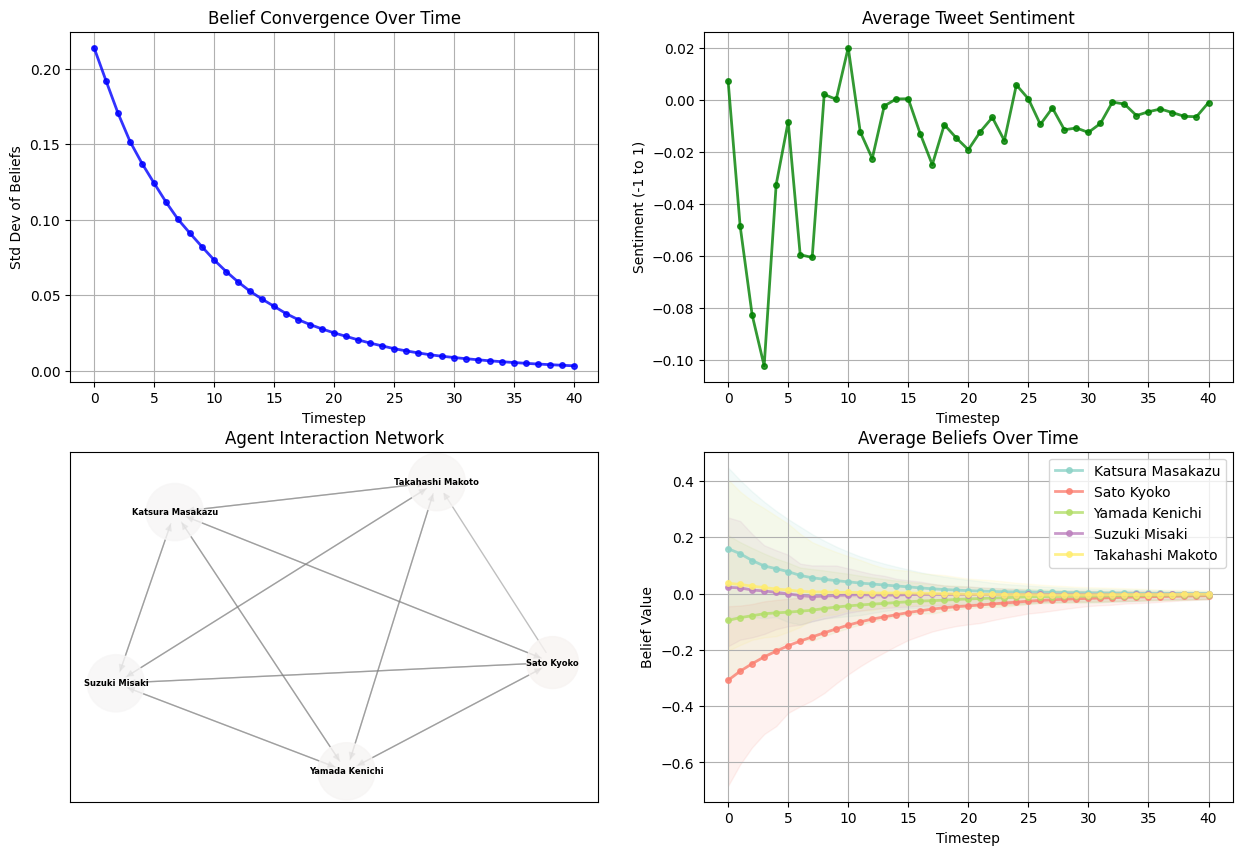

In [39]:
def main():
    """Main execution function"""
    # Initialize agents
    agents = []
    for i, persona in enumerate(JAPANESE_PERSONAS):
        agent = CPCAgent(
            id=f"agent_{i}",
            persona=persona,
            beliefs=np.zeros(len(JAPANESE_POLITICAL_TOPICS)),  # Will be initialized in __post_init__
            belief_precision=np.ones(len(JAPANESE_POLITICAL_TOPICS))
        )
        agents.append(agent)
    
    # Initialize components
    cpc_theory = CPCTheory(learning_rate=0.1, decay_rate=0.95)
    tweet_generator = TweetGenerator(client=openai_client, model="gpt-3.5-turbo")
    
    # Create simulation
    simulation = TwitterSimulation(agents, cpc_theory, tweet_generator)
    
    # Run simulation
    n_timesteps = 41  # Adjust as needed
    metrics = simulation.run_simulation(n_timesteps)
    
    # Visualize results
    visualize_results(simulation, metrics)
    
    # Analyze information diffusion
    analyze_information_diffusion(simulation)
    
    # Save results - use utility function to ensure JSON serialization
    results = {
        'metrics': make_json_serializable(metrics),
        'tweets': [{
            'id': t.id,
            'author': simulation.agents[t.author_id].persona['name'],
            'content': t.content,
            'topic': t.topic,
            'sentiment': make_json_serializable(t.sentiment),
            'is_quote': t.is_quote_tweet
        } for t in (simulation.all_tweets[-50:] if simulation.all_tweets else [])],  # Last 50 tweets
        'final_beliefs': {agent.id: make_json_serializable(agent.beliefs) 
                         for agent in simulation.agents.values()}
    }
    
    with open('simulation_results.json', 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=2)
    
    print("\nResults saved to simulation_results.json")
    
    return simulation, metrics

# Run the simulation
if __name__ == "__main__":
    simulation, metrics = main()

## 8. Additional Analysis Functions

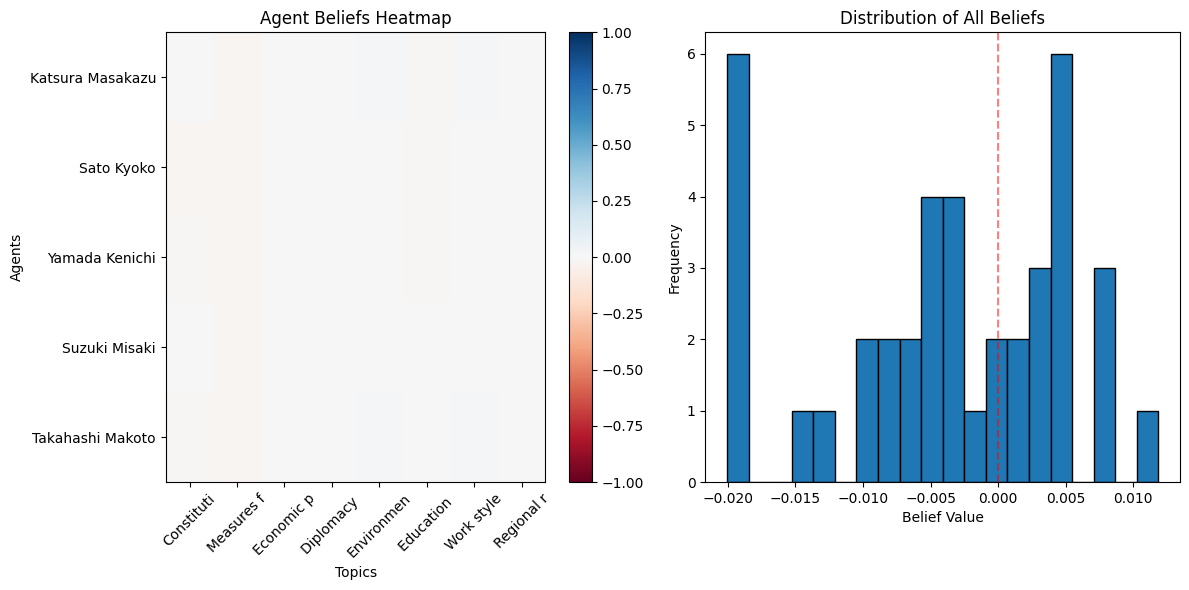

In [40]:
def analyze_belief_polarization(simulation: TwitterSimulation):
    """Analyze belief polarization across agents"""
    beliefs_matrix = np.array([agent.beliefs for agent in simulation.agents.values()])
    
    plt.figure(figsize=(12, 6))
    
    # Heatmap of beliefs
    plt.subplot(1, 2, 1)
    im = plt.imshow(beliefs_matrix, cmap='RdBu', vmin=-1, vmax=1, aspect='auto')
    plt.colorbar(im)
    plt.xlabel('Topics')
    plt.ylabel('Agents')
    plt.title('Agent Beliefs Heatmap')
    plt.xticks(range(len(JAPANESE_POLITICAL_TOPICS)), 
               [t[:10] for t in JAPANESE_POLITICAL_TOPICS], rotation=45)
    plt.yticks(range(len(simulation.agents)), 
               [a.persona['name'] for a in simulation.agents.values()])
    
    # Distribution of beliefs
    plt.subplot(1, 2, 2)
    plt.hist(beliefs_matrix.flatten(), bins=20, edgecolor='black')
    plt.xlabel('Belief Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of All Beliefs')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Run additional analysis
if 'simulation' in locals():
    analyze_belief_polarization(simulation)